In [163]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
#Feature importances
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [164]:
# https://www.kaggle.com/code/datafan07/icr-simple-eda-baseline
def balance_logloss(y_true, y_pred):
    
    y_pred = np.stack([1-y_pred,y_pred]).T
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    
    return logloss



In [165]:
# clean features
def clean_features(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.replace(' ', '') # remove spaces
    df = df.fillna(df.mean(numeric_only=True))
    df["EJ"] = np.where(df["EJ"] == "A", 1, 0)
    return df

In [166]:
#Descripe the data
def getDescription(df): 
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first quartile'] = desc.loc[:, '25%'].values
    summ['second quartile'] = desc.loc[:, '50%'].values
    summ['third quartile'] = desc.loc[:, '75%'].values
    return summ

In [167]:
raw = pd.read_csv("./data/train.csv")
greeks = pd.read_csv("./data/greeks.csv")
test = pd.read_csv("./data/test.csv")

In [168]:
# df = pd.merge(raw, greeks, on="Id")
df = raw.copy()

In [169]:
getDescription(df)

data type  #missing  %missing  #unique          min          max  \
Id       object         0  0.000000      617          NaN          NaN   
AB      float64         0  0.000000      217     0.081187     6.161666   
AF      float64         0  0.000000      599    192.59328  28688.18766   
AH      float64         0  0.000000      227    85.200147  1910.123198   
AM      float64         0  0.000000      605     3.177522    630.51823   
AR      float64         0  0.000000      130     8.138688   178.943634   
AX      float64         0  0.000000      427     0.699861     38.27088   
AY      float64         0  0.000000      148     0.025578    10.315851   
AZ      float64         0  0.000000      484     3.396778    38.971568   
BC      float64         0  0.000000      259       1.2299  1463.693448   
BD      float64         0  0.000000      617   1693.62432  53060.59924   
BN      float64         0  0.000000       53       9.8868      29.3073   
BP      float64         0  0.000000      612    72.948951   2447.81055   
BQ      float64        60  9.724473      515     1.331155   344.644105   
BR      float64         0  0.000000      566    51.216883  179250.2529   
BZ      float64         0  0.000000      115   257.432377   50092.4593   
CB      float64         2  0.324149      553     12.49976  2271.436167   
CC      float64         3  0.486224      602     0.176874     4.103032   
CD      float64         0  0.000000      584      23.3876   633.534408   
CF      float64         0  0.000000      586     0.510888   200.967526   
CH      float64         0  0.000000      135     0.003184     0.224074   
CL      float64         0  0.000000      123     1.050225    31.688153   
CR      float64         0  0.000000      595     0.069225     3.039675   
CS      float64         0  0.000000      576    13.784111   267.942823   
CU      float64         0  0.000000      307     0.137925     4.951507   
CW      float64         0  0.000000      426      7.03064    64.521624   
DA      float64         0  0.000000      611       6.9064    210.33092   
DE      float64         0  0.000000      616    35.998895   2103.40519   
DF      float64         0  0.000000      137      0.23868    37.895013   
DH      float64         0  0.000000      191     0.040995     1.060404   
DI      float64         0  0.000000      571     60.23247  1049.168078   
DL      float64         0  0.000000      604      10.3456     326.2362   
DN      float64         0  0.000000      576     6.339496    62.808096   
DU      float64         1  0.162075      253     0.005518   161.355315   
DV      float64         0  0.000000       39      1.74307     25.19293   
DY      float64         0  0.000000      590     0.804068   152.355164   
EB      float64         0  0.000000      439     4.926396     94.95858   
EE      float64         0  0.000000      513     0.286201    18.324926   
EG      float64         0  0.000000      610     185.5941  30243.75878   
EH      float64         0  0.000000      127     0.003042    42.569748   
EJ       object         0  0.000000        2          NaN          NaN   
EL      float64        60  9.724473      311     5.394675   109.125159   
EP      float64         0  0.000000      275    78.526968  1063.594578   
EU      float64         0  0.000000      455     3.828384   6501.26448   
FC      float64         1  0.162075      600     7.534128  3030.655824   
FD      float64         0  0.000000      337      0.29685  1578.654237   
FE      float64         0  0.000000      615  1563.136688  143224.6823   
FI      float64         0  0.000000      498      3.58345    35.851039   
FL      float64         1  0.162075      388     0.173229   137.932739   
FR      float64         0  0.000000      435      0.49706   1244.22702   
FS      float64         2  0.324149      161      0.06773    31.365763   
GB      float64         0  0.000000      560     4.102182   135.781294   
GE      float64         0  0.000000      264    72.611063  1497.351958   
GF      fl

In [170]:
df  = df.pipe(clean_features)

## Quick EDA

In [171]:
df.select_dtypes(include=[np.number]).columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [172]:
numeric_features = df.select_dtypes(include=[np.number]).columns
#pop EJ
numeric_features = numeric_features.drop(["EJ", "Class"])


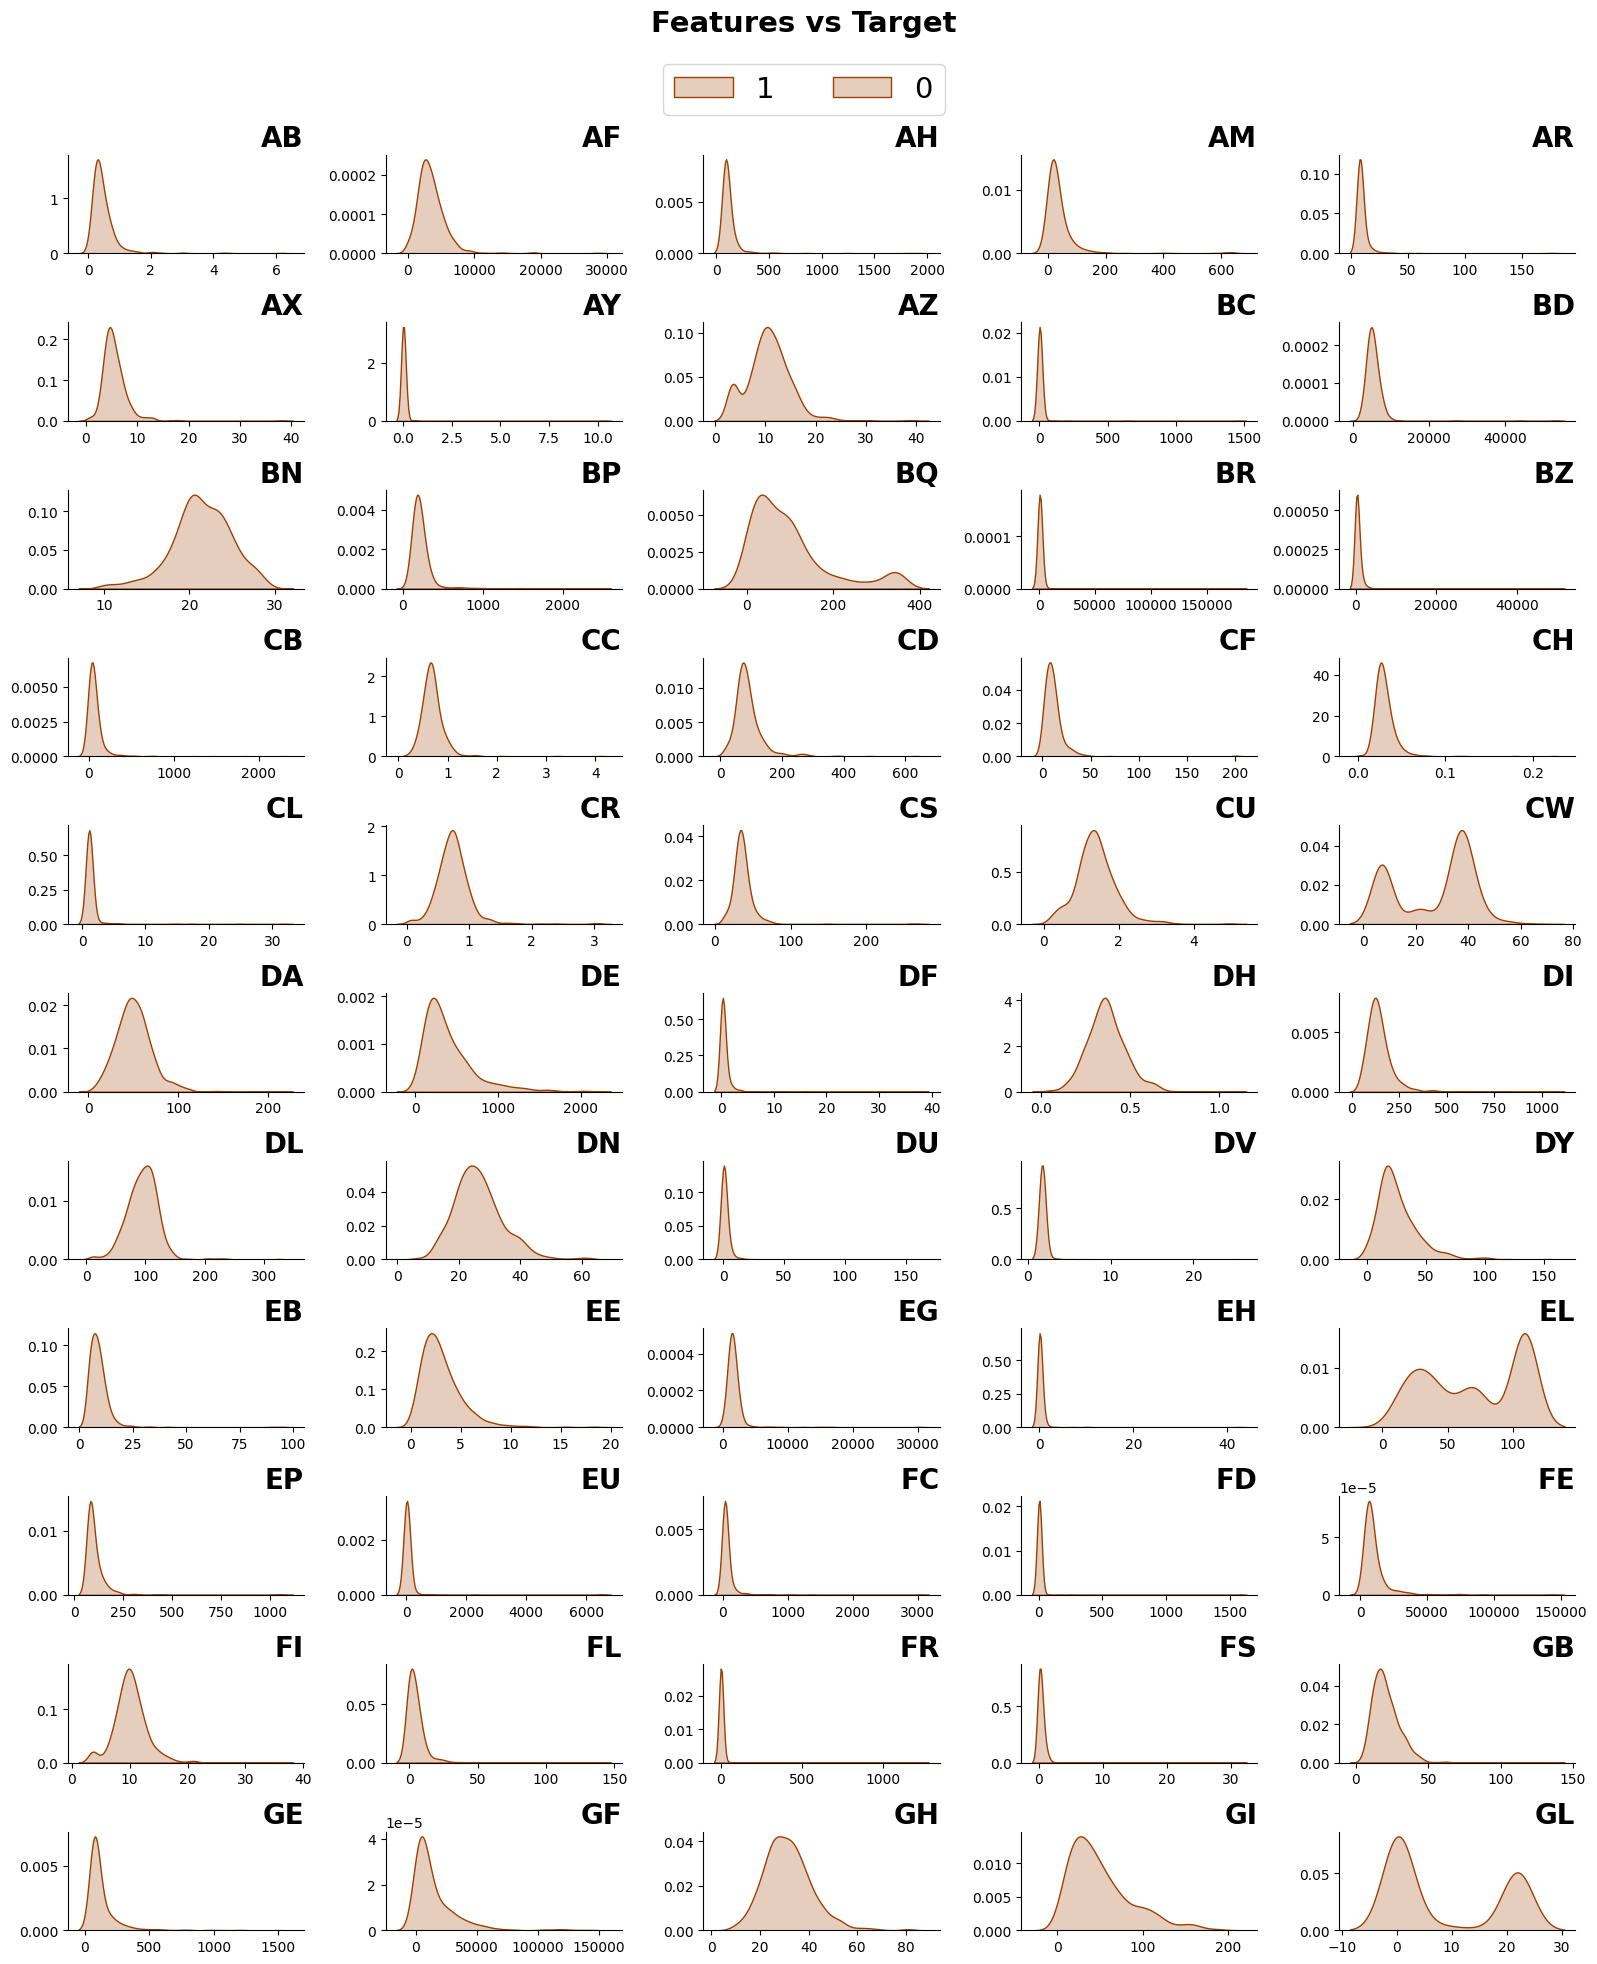

In [173]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(numeric_features):
    ax = plt.subplot(11,5, idx + 1)
    sns.kdeplot(
        data=df, fill=True,
        x=col, color='#9E3F00', legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

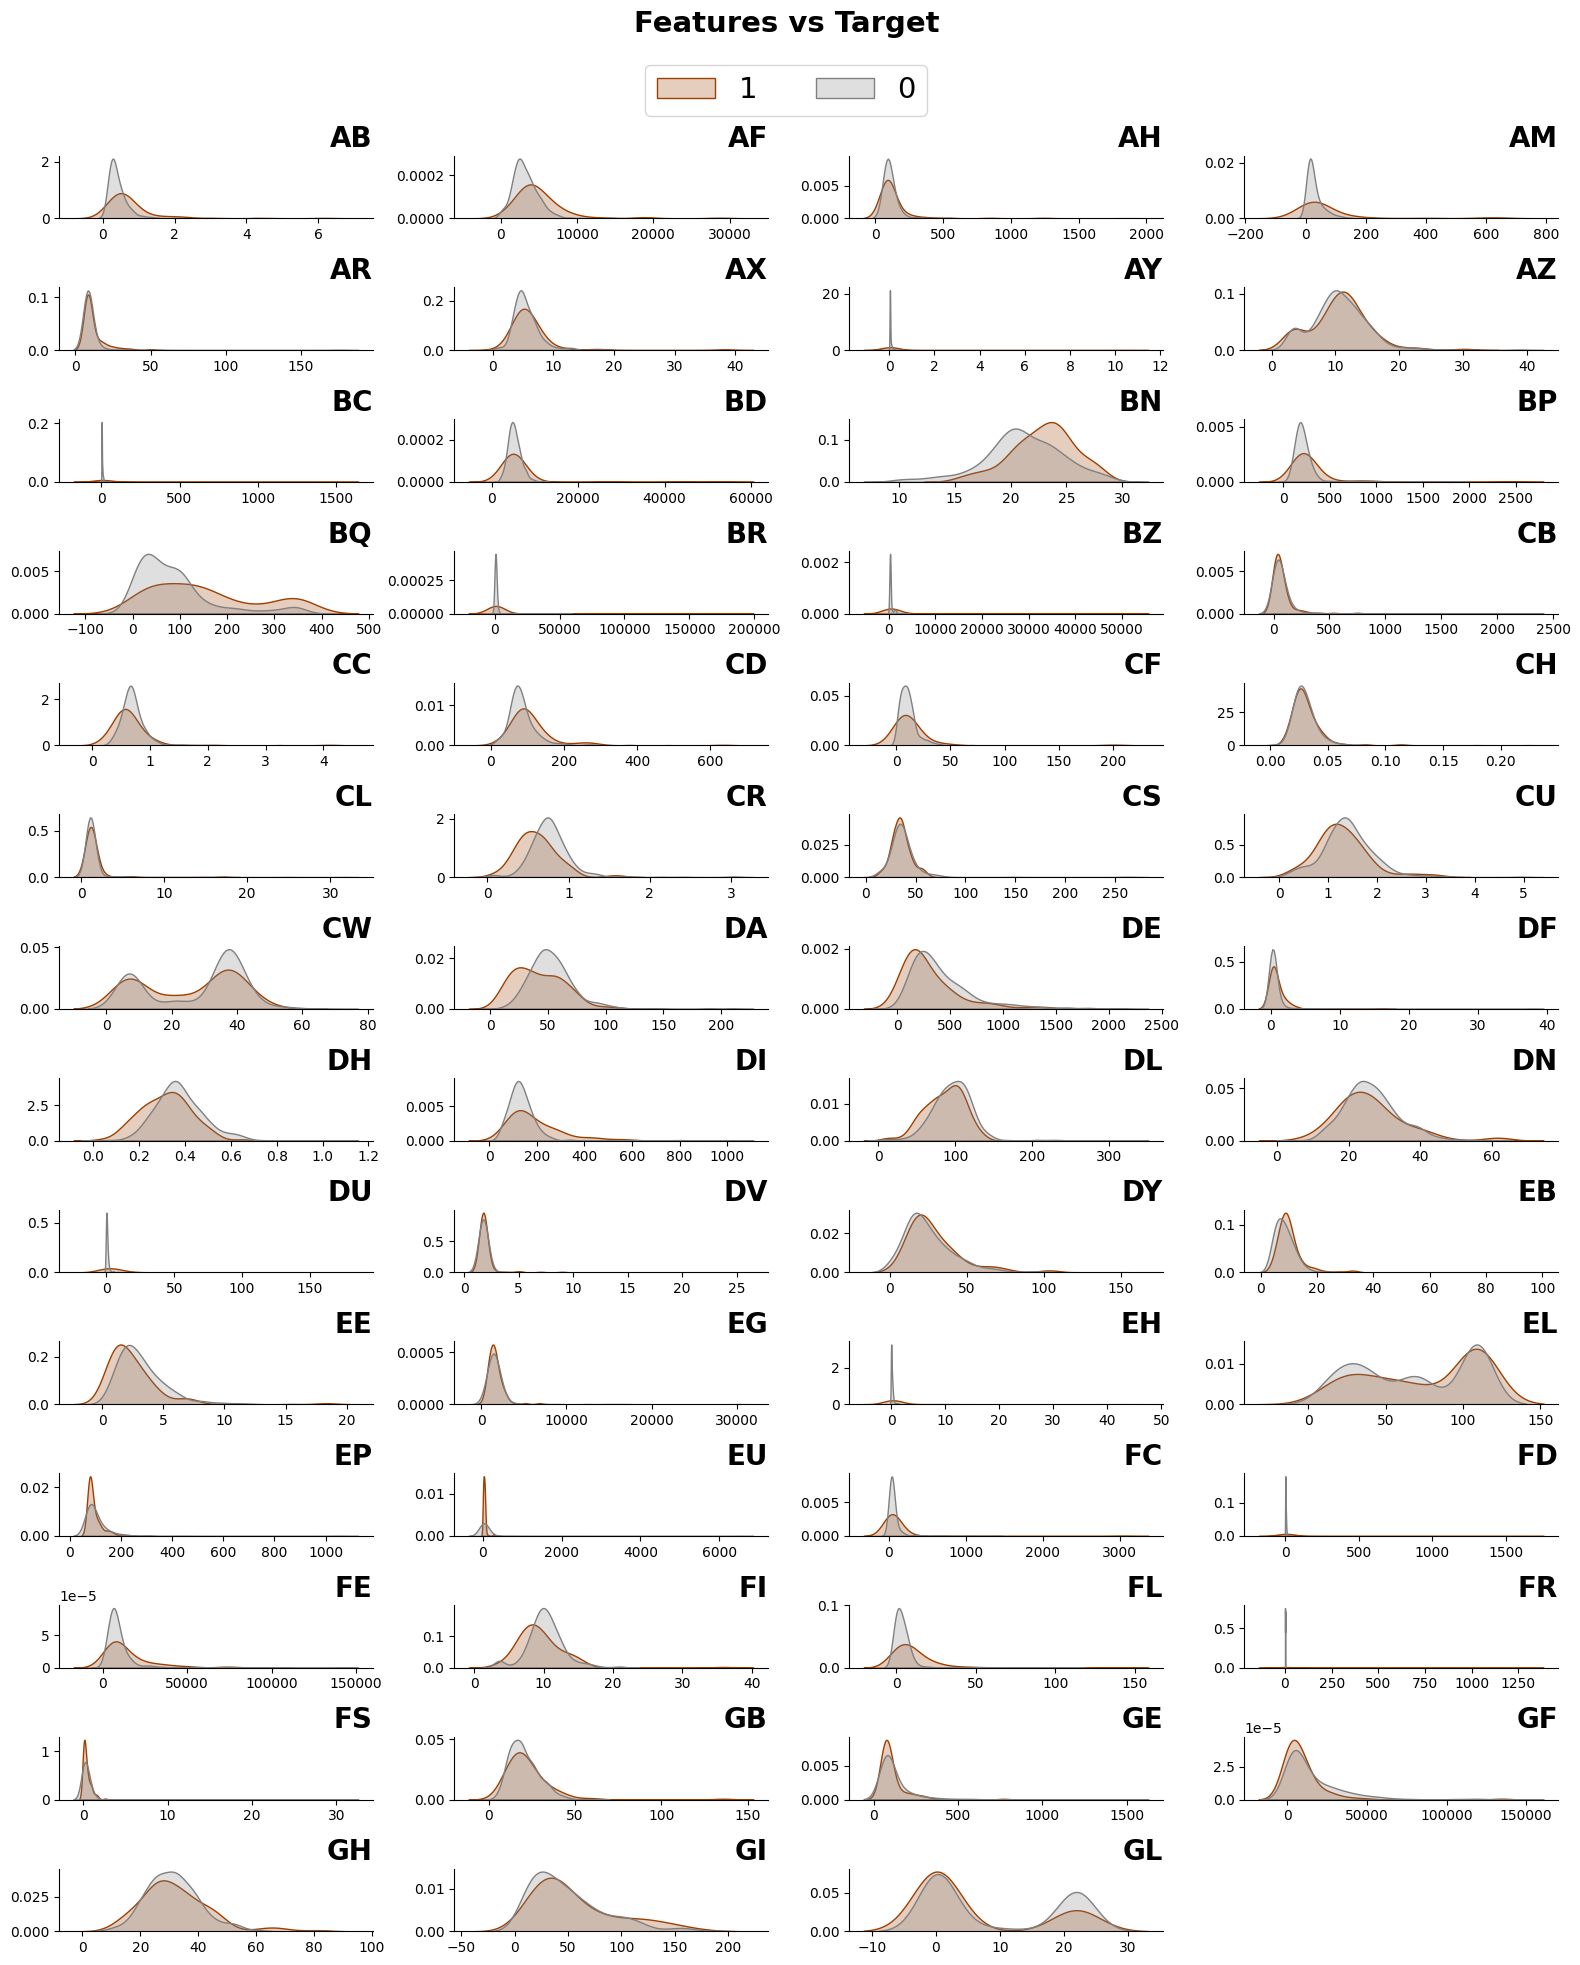

In [174]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(numeric_features):
    ax = plt.subplot(14,4, idx + 1)
    sns.kdeplot(
        data=df[df["Class"]==1], fill=True,
        x=col, color='#9E3F00', legend=False
    )
    sns.kdeplot(
        data=df[df["Class"]==0], fill=True,
        x=col, color='gray', legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

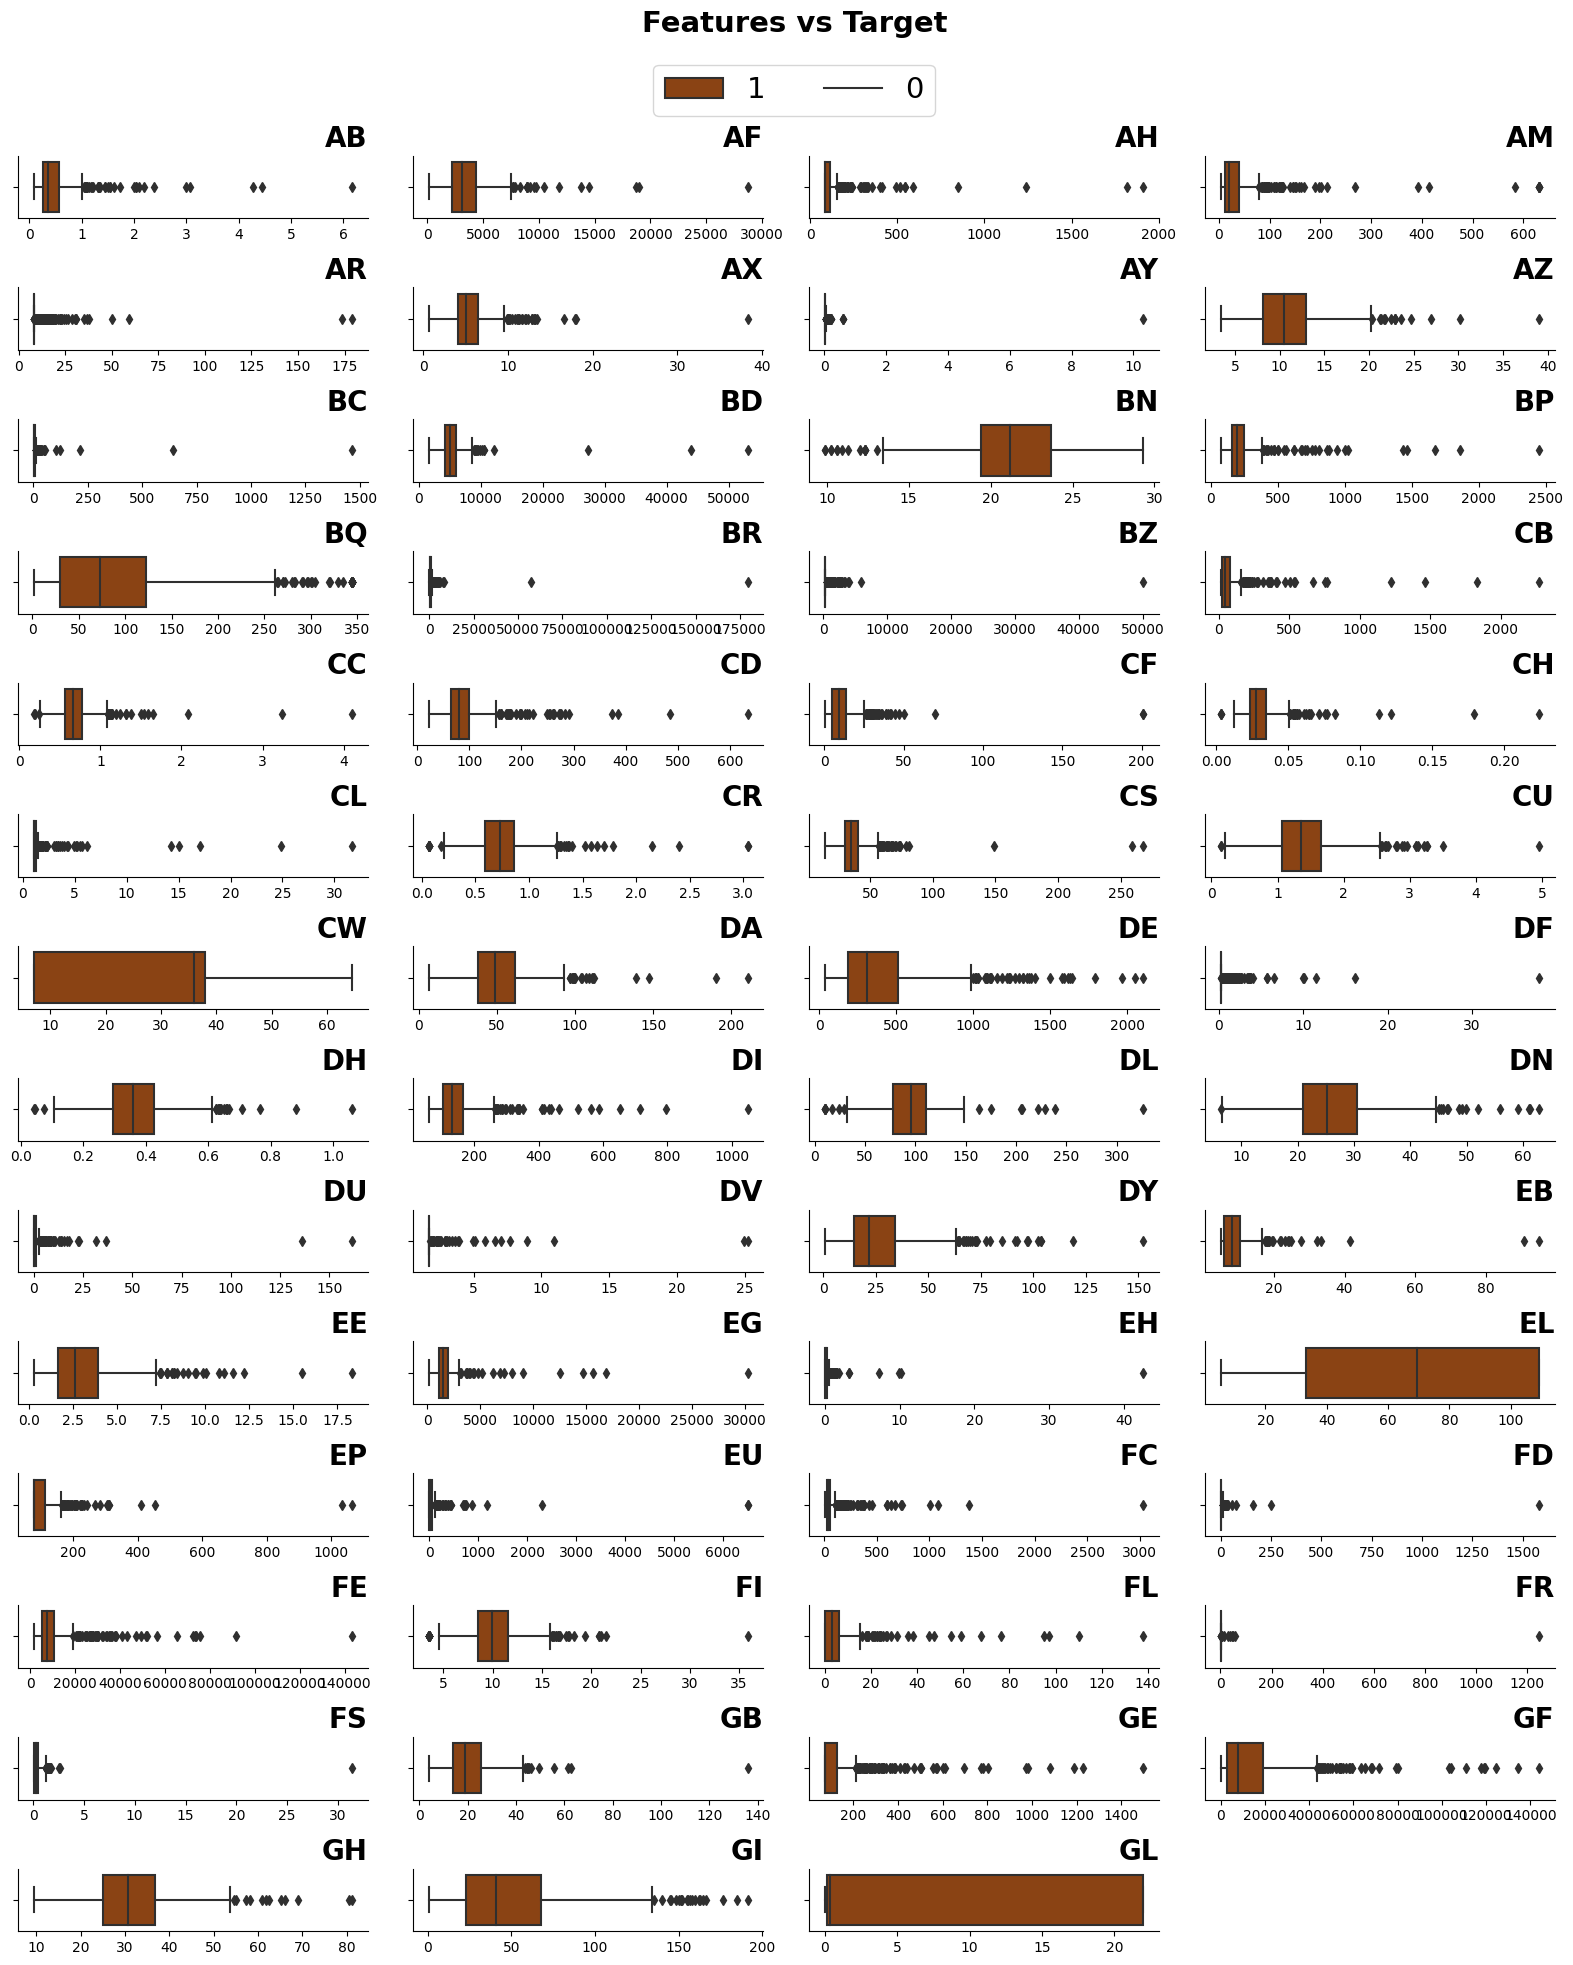

In [175]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(numeric_features):
    ax = plt.subplot(14,4, idx + 1)
    sns.boxplot(
        data=df,
        x=col, color='#9E3F00'
    )

            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

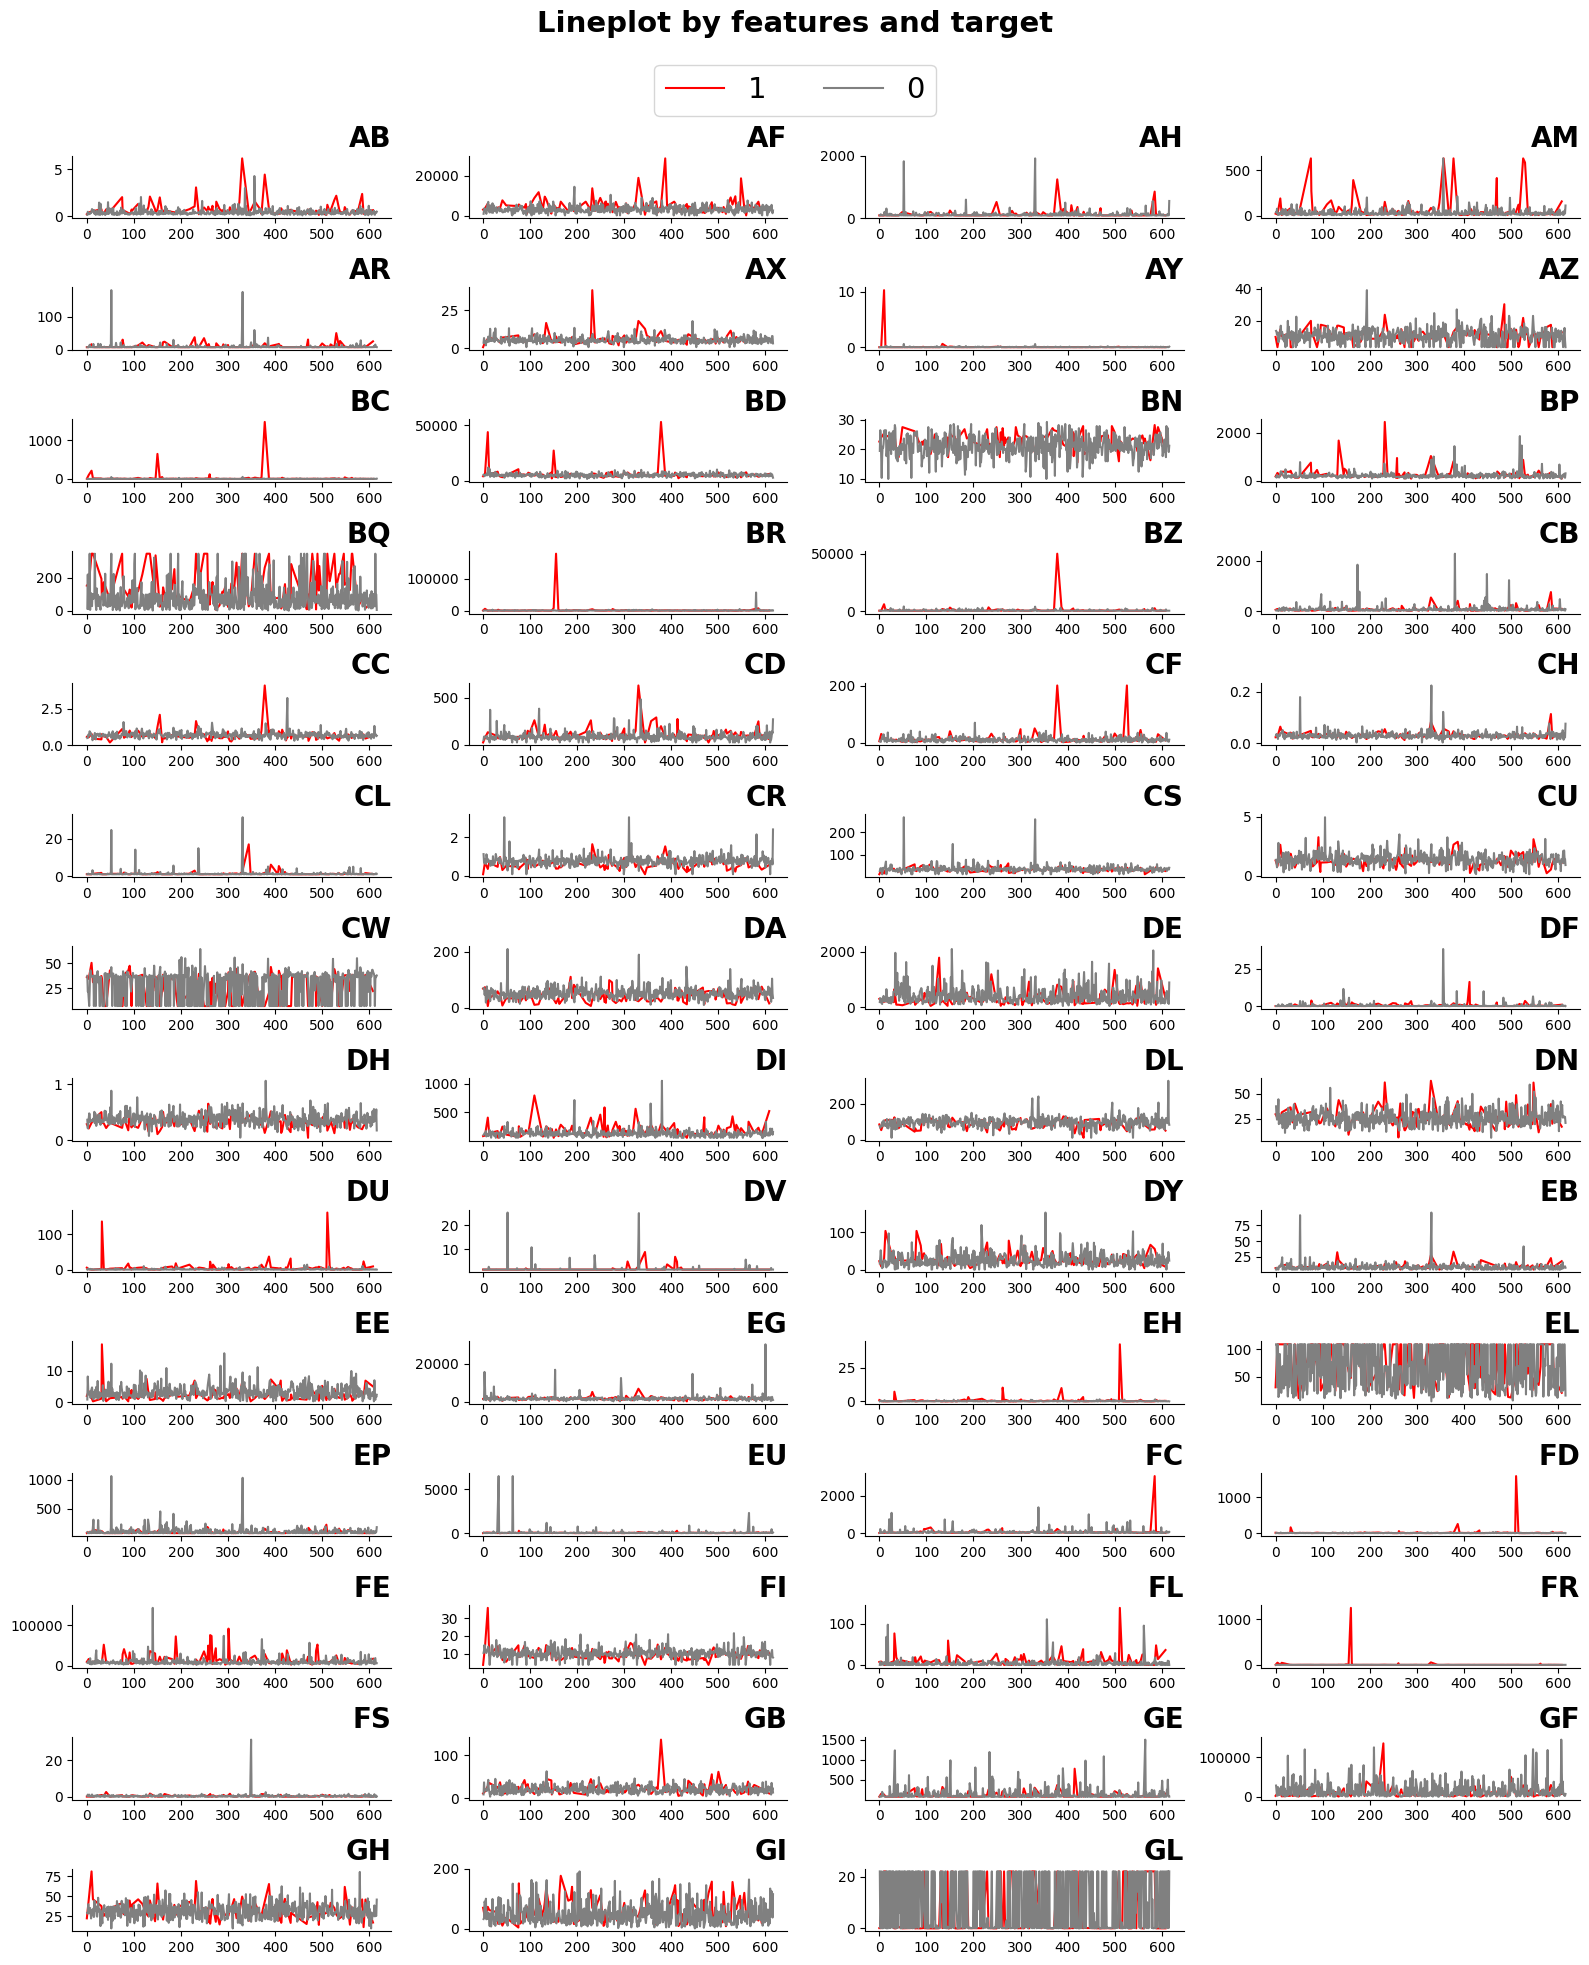

In [176]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(numeric_features):
    ax = plt.subplot(14,4, idx + 1)
    df.loc[df["Class"]==1, col].plot(kind="line", ax=ax, color='red')
    df.loc[df["Class"]==0, col].plot(kind="line", ax=ax, color='gray')

            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Lineplot by features and target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

## We need to see this graph a bit more detailed. Lets plot each individual
We add also horizontal lines that segment the data

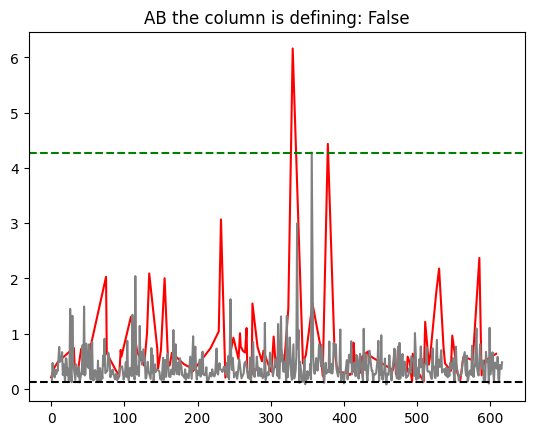

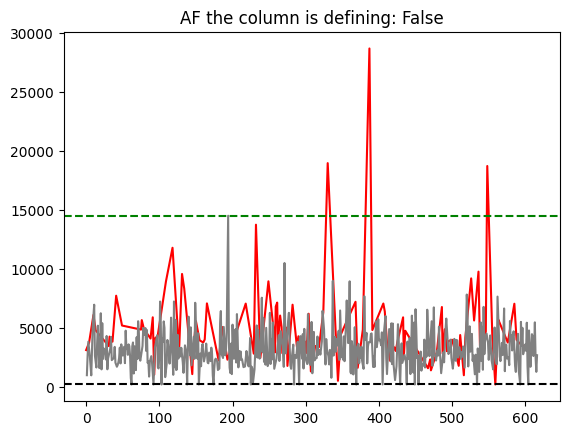

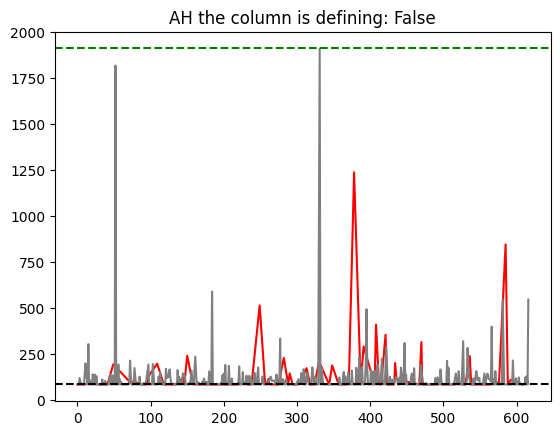

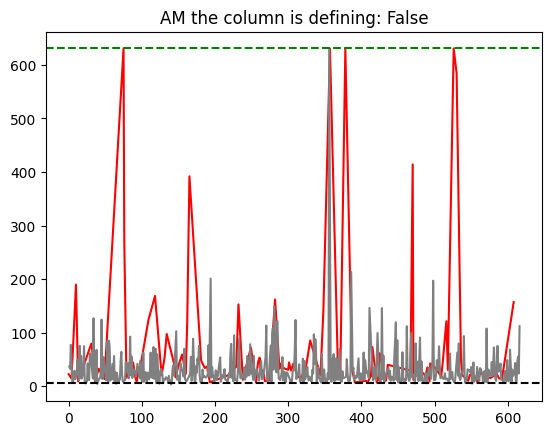

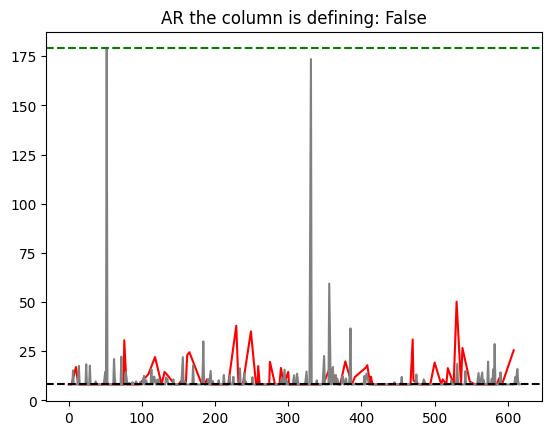

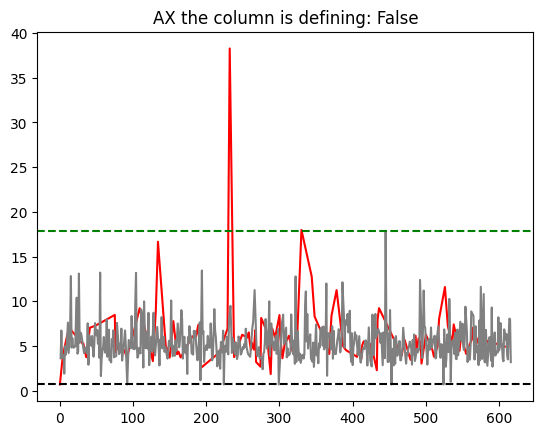

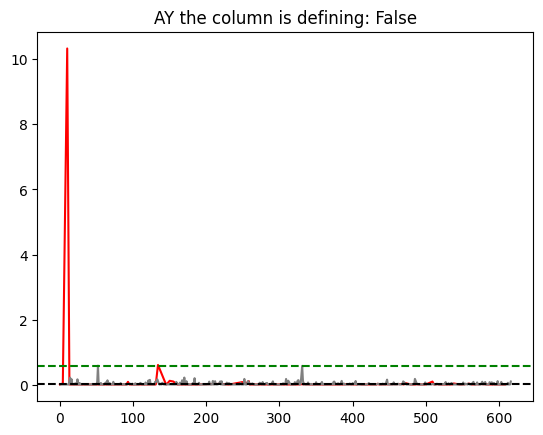

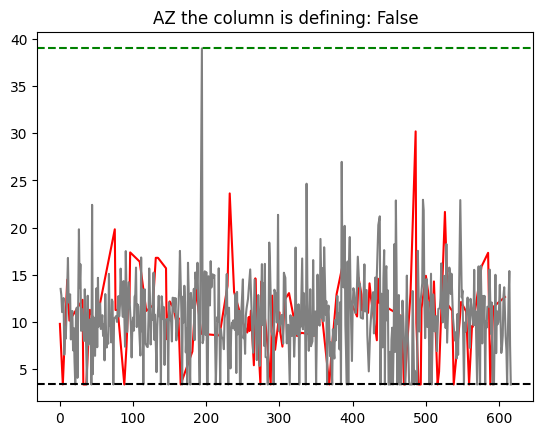

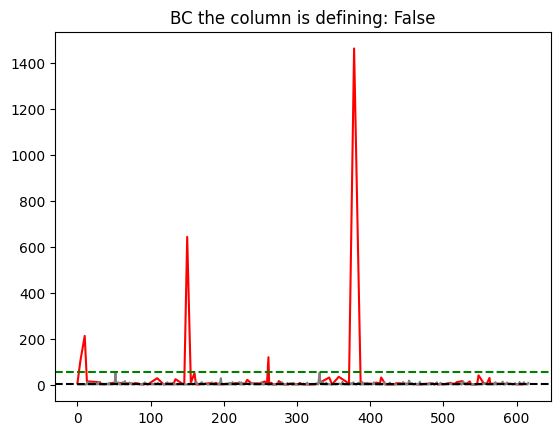

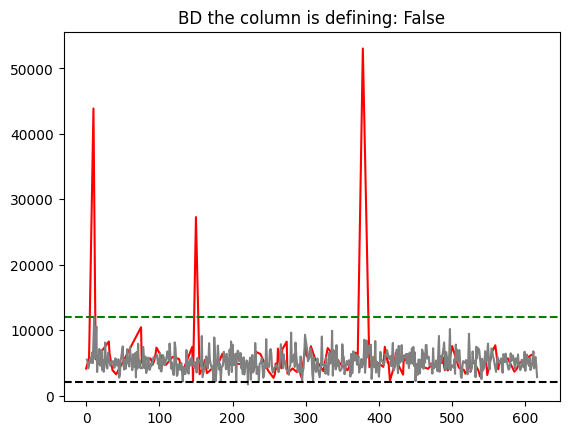

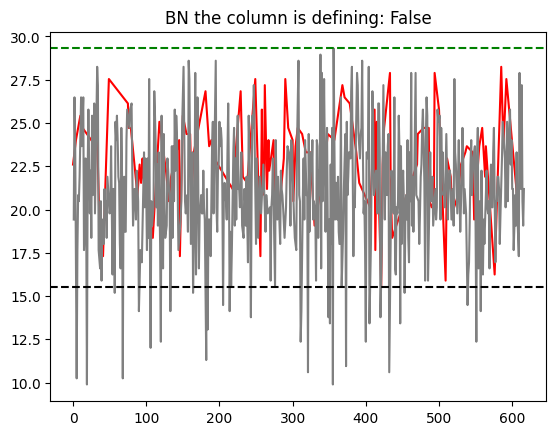

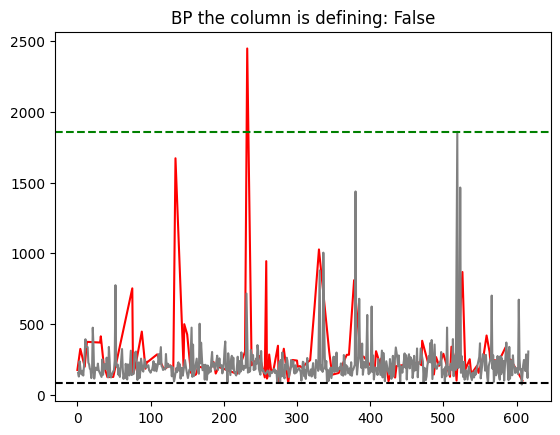

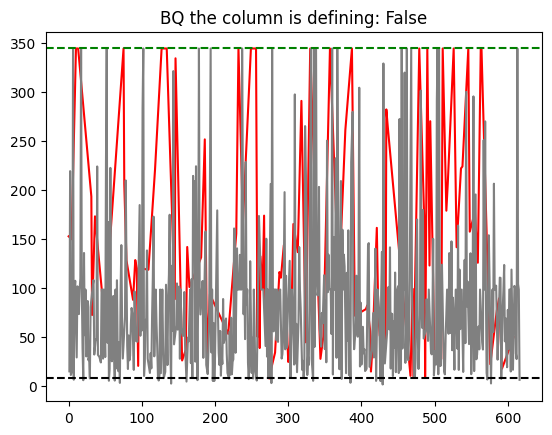

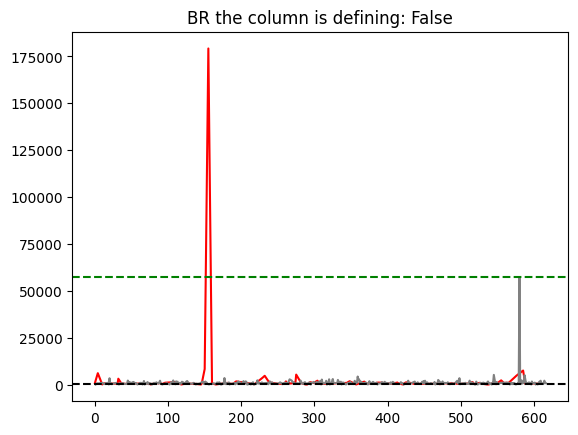

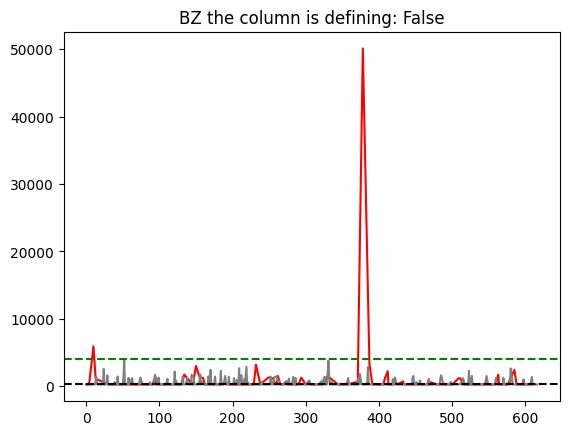

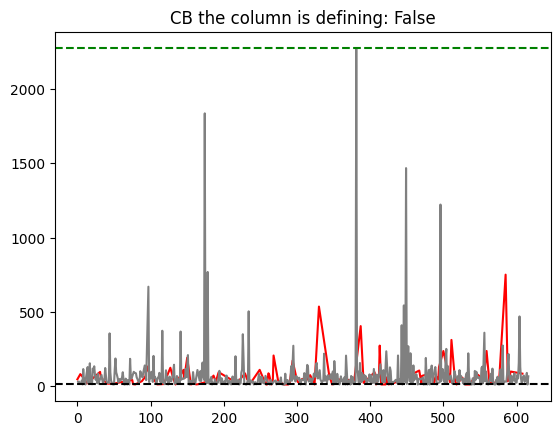

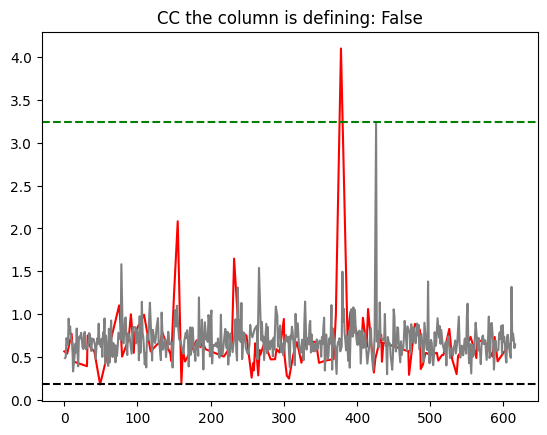

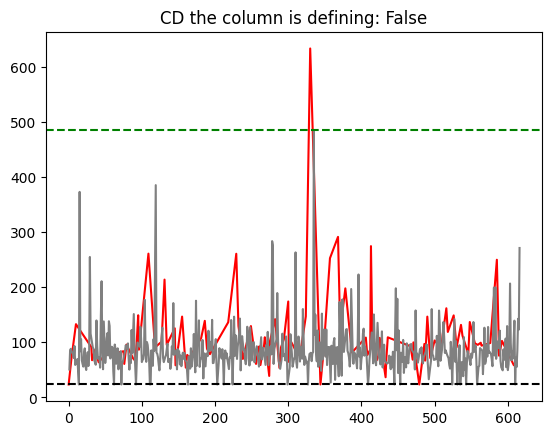

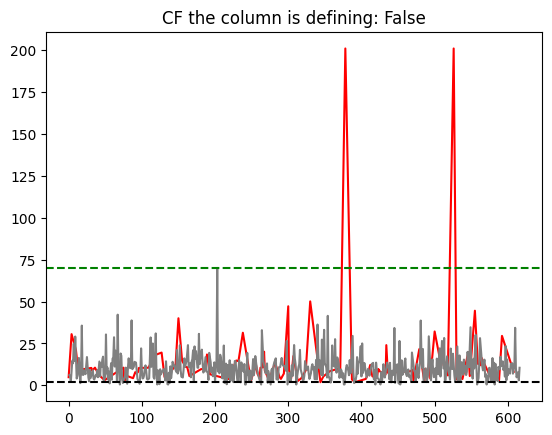

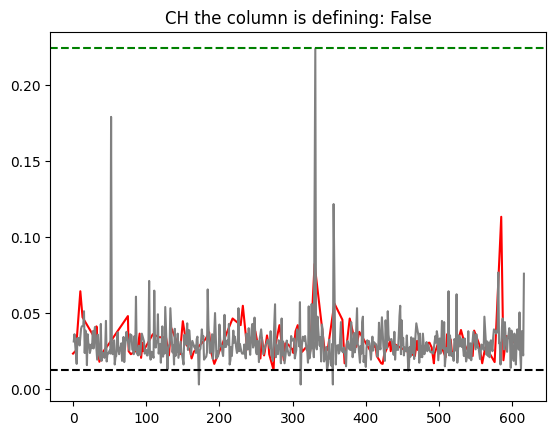

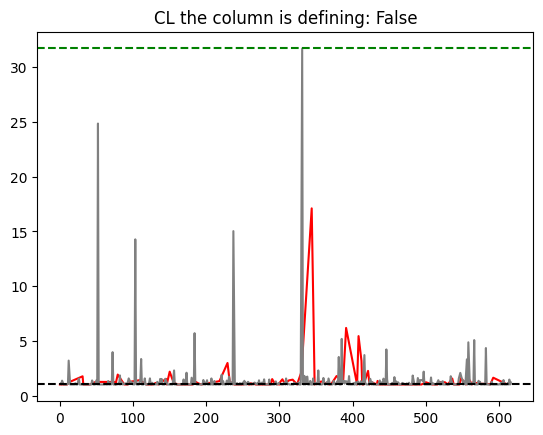

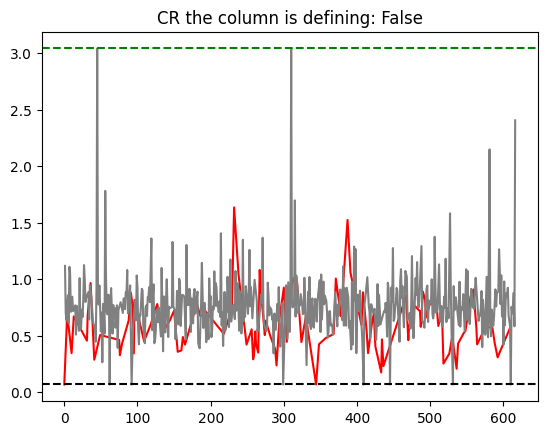

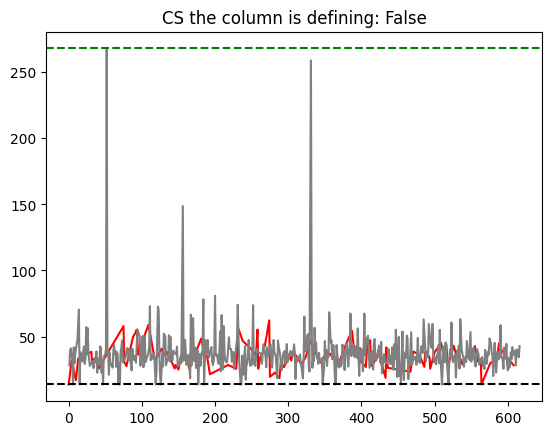

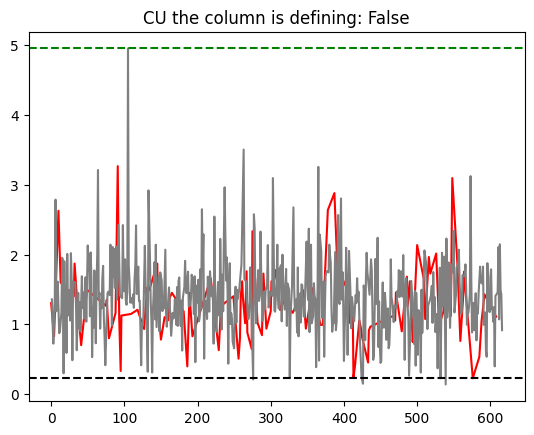

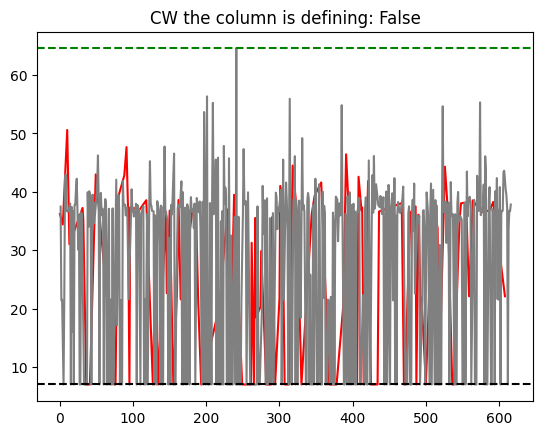

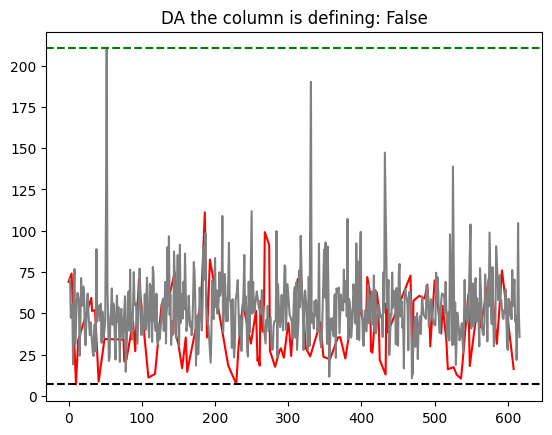

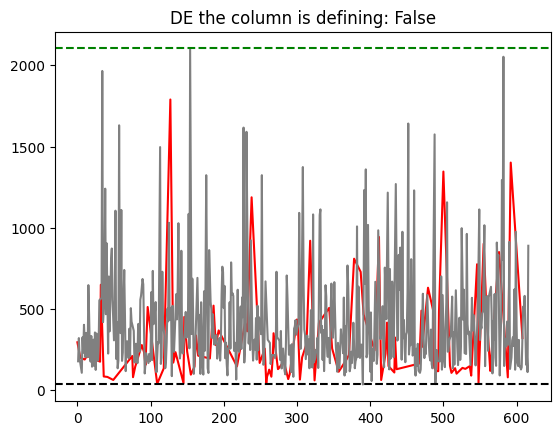

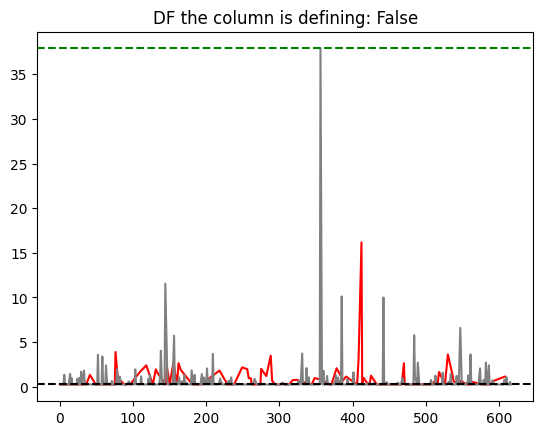

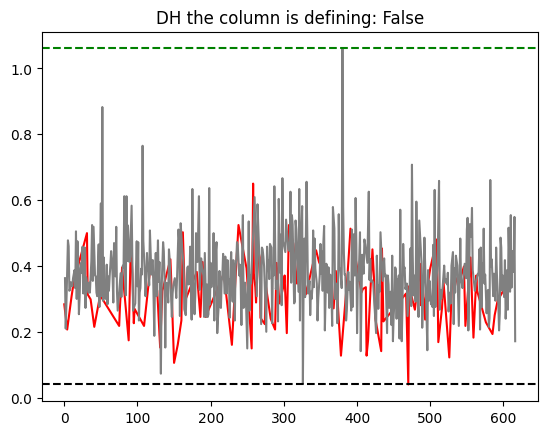

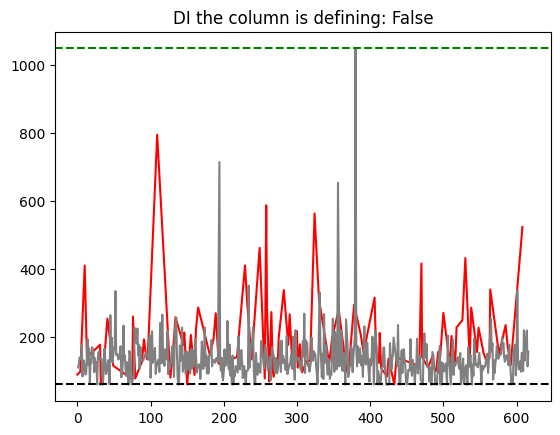

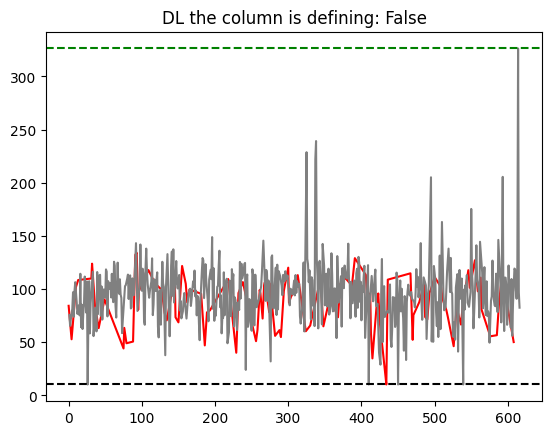

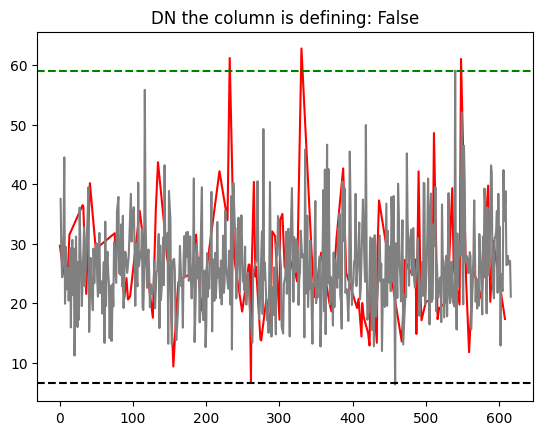

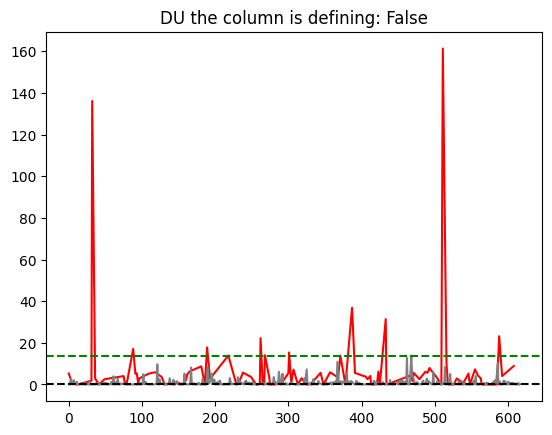

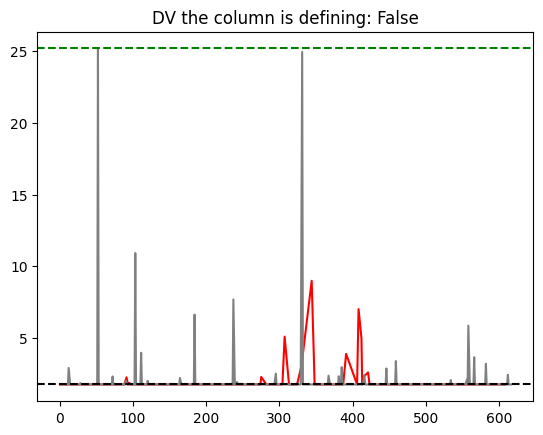

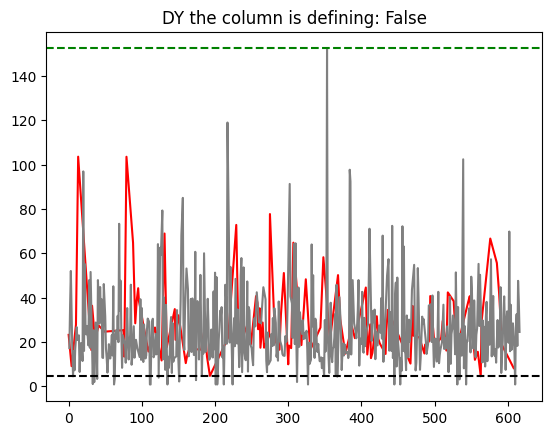

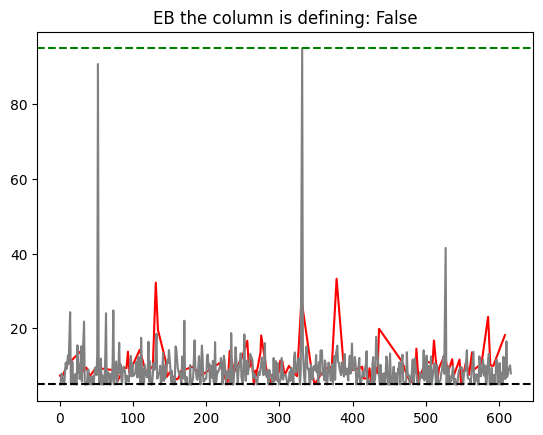

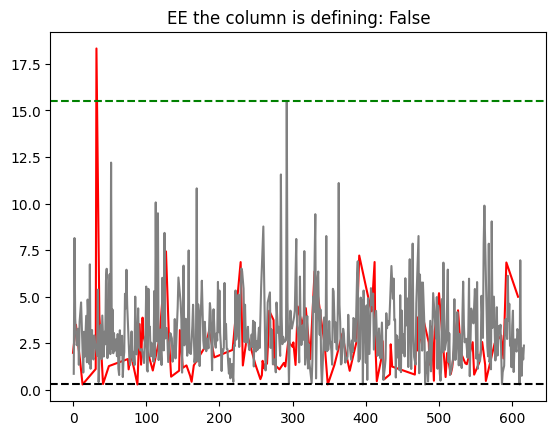

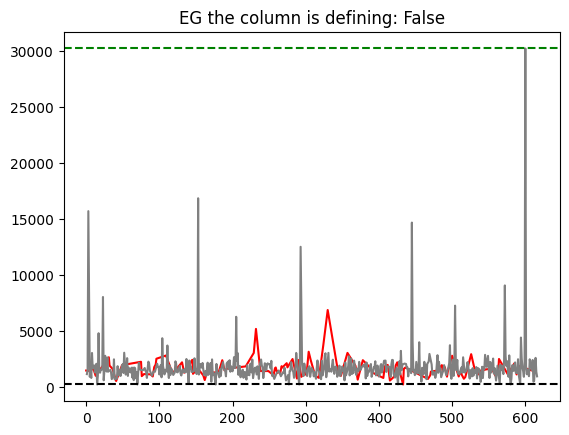

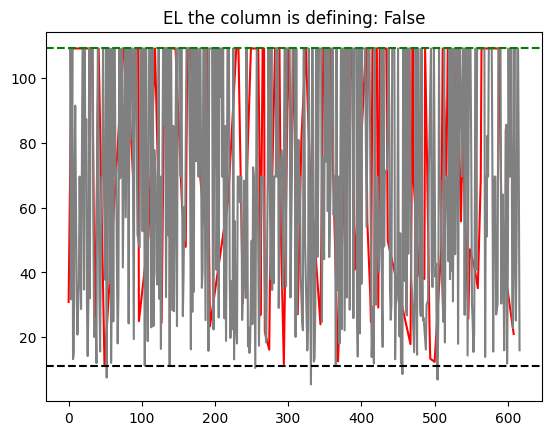

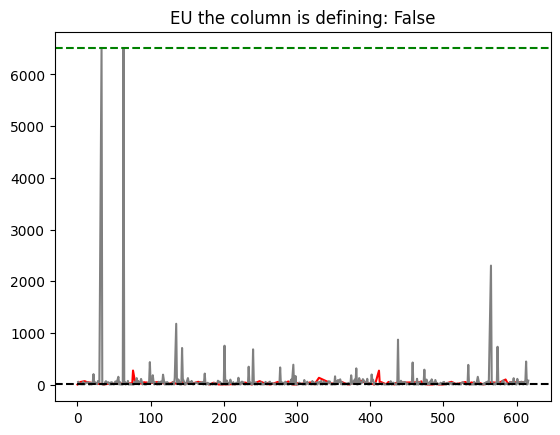

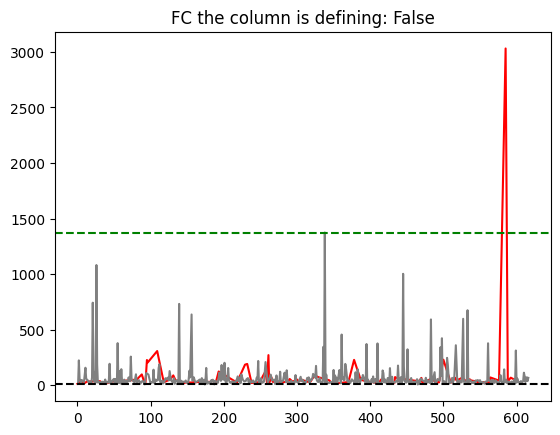

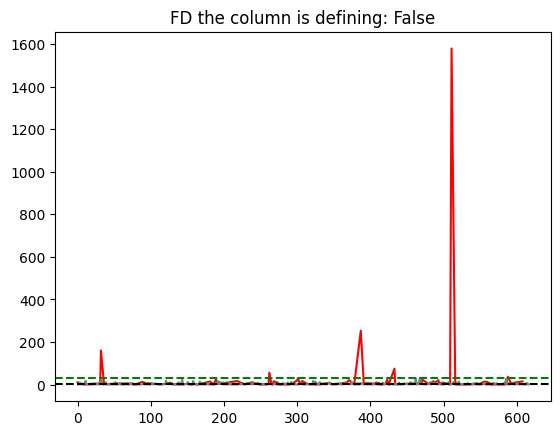

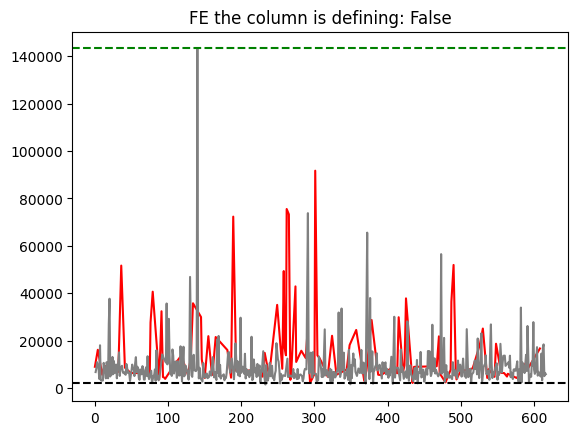

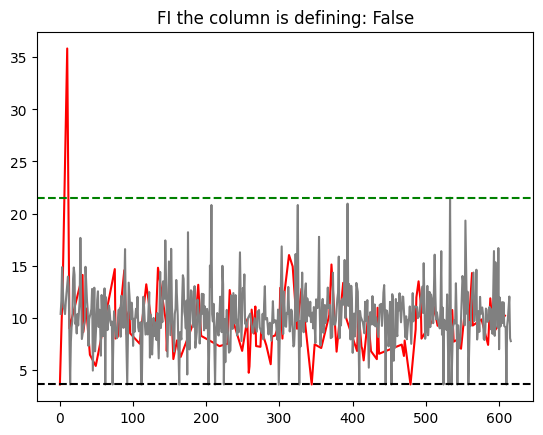

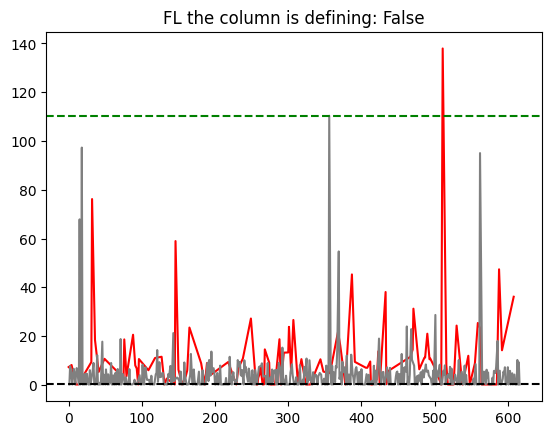

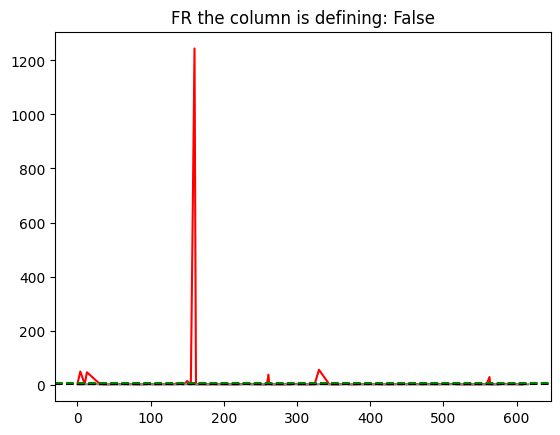

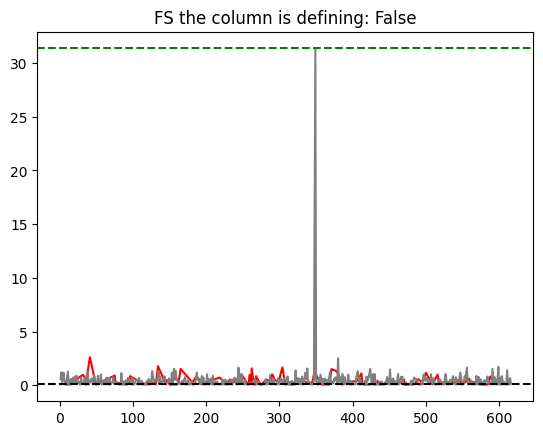

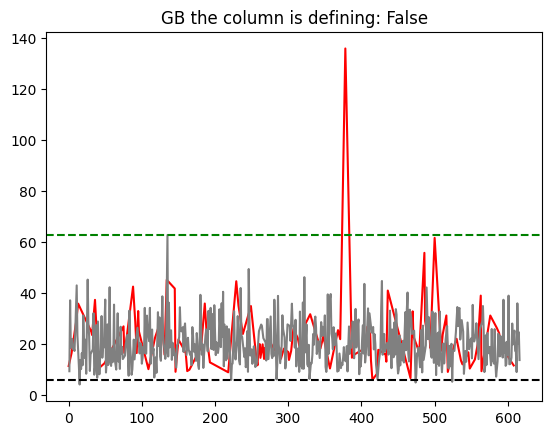

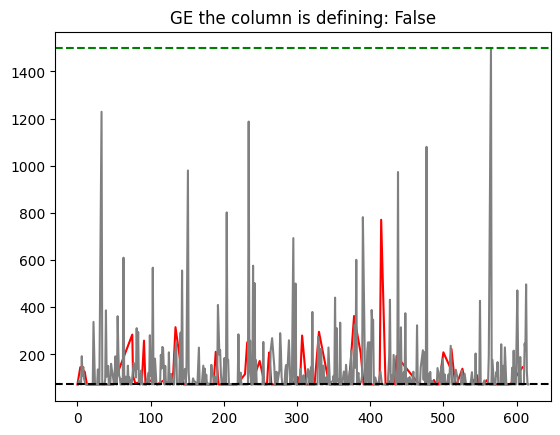

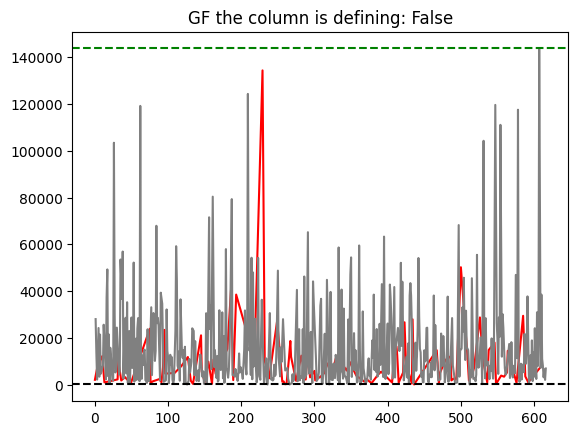

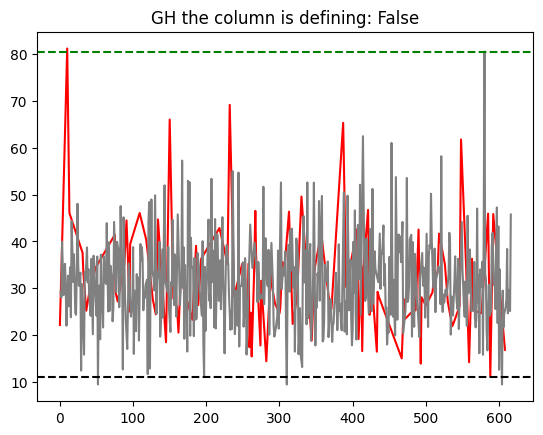

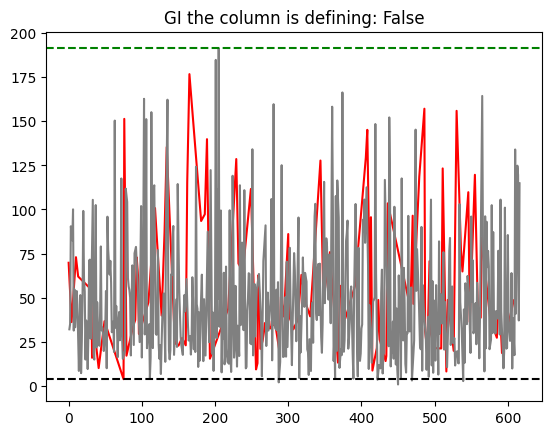

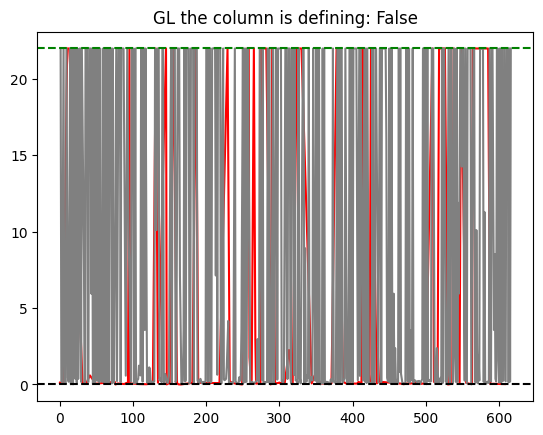

In [177]:
for idx, col in enumerate(numeric_features):
    df.loc[df["Class"]==1, col].plot(kind="line",  color='red')
    df.loc[df["Class"]==0, col].plot(kind="line",  color='gray')

    plt.axhline(y=df.loc[df["Class"]==1, col].min(), color='black', linestyle='--')
    plt.axhline(y=df.loc[df["Class"]==0, col].max(), color='green', linestyle='--')


    # if df.loc[df["Class"]==1, col].min() > df.loc[df["Class"]==0, col].max():
    #     plt.axhline(y=df.loc[df["Class"]==1, col].min(), color='black', linestyle='-')
    # else:
    #     plt.axhline(y=df.loc[df["Class"]==0, col].max(), color='black', linestyle='-')


    if df.loc[df["Class"]==1, col].min() > df.loc[df["Class"]==0, col].max():
        is_defining = True

    else:
        is_defining = False


    plt.title(f'{col} the column is defining: {is_defining}')
    plt.show()

In [178]:
df.isna().sum()

Id       0
AB       0
AF       0
AH       0
AM       0
AR       0
AX       0
AY       0
AZ       0
BC       0
BD       0
BN       0
BP       0
BQ       0
BR       0
BZ       0
CB       0
CC       0
CD       0
CF       0
CH       0
CL       0
CR       0
CS       0
CU       0
CW       0
DA       0
DE       0
DF       0
DH       0
DI       0
DL       0
DN       0
DU       0
DV       0
DY       0
EB       0
EE       0
EG       0
EH       0
EJ       0
EL       0
EP       0
EU       0
FC       0
FD       0
FE       0
FI       0
FL       0
FR       0
FS       0
GB       0
GE       0
GF       0
GH       0
GI       0
GL       0
Class    0
dtype: int64

## Remove outliers
Lets do an outlier removal based on percentiles. But later we can also classify some outliers. Like record from specific columns that are significant, which outiliers we recentered and then adjust at the end the target

In [179]:
index = []
df_clean = df.copy()
# recenter to the lower or upper percentile
for col in numeric_features:
    
    lower_percentile,upper_percentile = np.percentile(df[col], [25,75])
    index.extend(df_clean[(df_clean[col] > upper_percentile*2.5) | (df_clean[col] < lower_percentile*0.5)].index)
    df_clean.loc[df_clean[col] > upper_percentile*2.5, col] = upper_percentile*2.5
    df_clean.loc[df_clean[col] < lower_percentile*0.5, col] = lower_percentile*0.5

index = list(set(index))

In [180]:
df_25_75 = np.percentile(df[numeric_features], [25,75], axis=0)


In [181]:
# Create a dataframe: 1st column is features (each row being one), second col is the 25th percentile*2.5, third col is the 75th percentile *0.5
df_25_75 = pd.DataFrame(np.concatenate([df_25_75[0].reshape(-1,1), df_25_75[1].reshape(-1,1)], axis=1), columns=["25th", "75th"], index=numeric_features)
df_25_75["25th"] = df_25_75["25th"]*0.5
df_25_75["75th"] = df_25_75["75th"]*2.5

In [182]:
df_25_75

25th          75th
AB     0.126054      1.399408
AF  1098.672740  10904.093475
AH    42.600074    284.348850
AM     6.135157     97.849715
AR     4.069344     20.346720
AX     2.064147     16.079085
AY     0.012789      0.092111
AZ     4.064790     32.423790
BC     0.614950     12.703110
BD  2077.851435  15089.714250
BN     9.710250     59.144250
BP    78.423620    619.508655
BQ    15.047783    307.227188
BR   212.495321   2439.123147
BZ   128.716188    643.580942
CB    11.658784    193.160354
CC     0.282155      1.929774
CD    32.362096    249.533800
CF     2.533153     33.914752
CH     0.011741      0.086067
CL     0.525112      3.071112
CR     0.294787      2.148375
CS    14.891234    101.323503
CU     0.535149      4.151542
CW     3.515320     94.839580
DA    18.971260    153.521900
DE    94.407845   1269.740500
DF     0.119340      0.596700
DH     0.147582      1.065870
DI    51.351776    414.592387
DL    39.116120    276.601700
DN    10.444132     76.360560
DU     0.002759      2.672587
DV     0.871535      4.357675
DY     7.357896     85.145860
EB     2.982696     26.257620
EE     0.824340      9.775175
EG   555.580312   4764.253688
EH     0.001521      0.593190
EL    16.684668    272.812897
EP    39.263484    281.916635
EU     2.162328    122.713380
FC    12.920544    141.871800
FD     0.148425     12.200535
FE  2582.333130  26619.879125
FI     4.261549     28.791643
FL     0.086614     15.593322
FR     0.248530      3.780150
FS     0.033865      1.337667
GB     7.018359     64.021015
GE    36.305532    318.979176
GF  1399.496292  47589.273100
GH    12.517444     92.159868
GI    11.505842    169.829160
GL     0.062207     54.945000

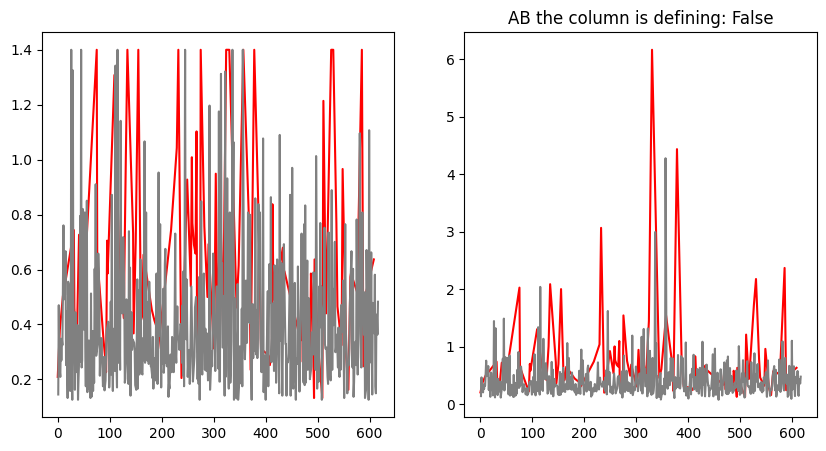

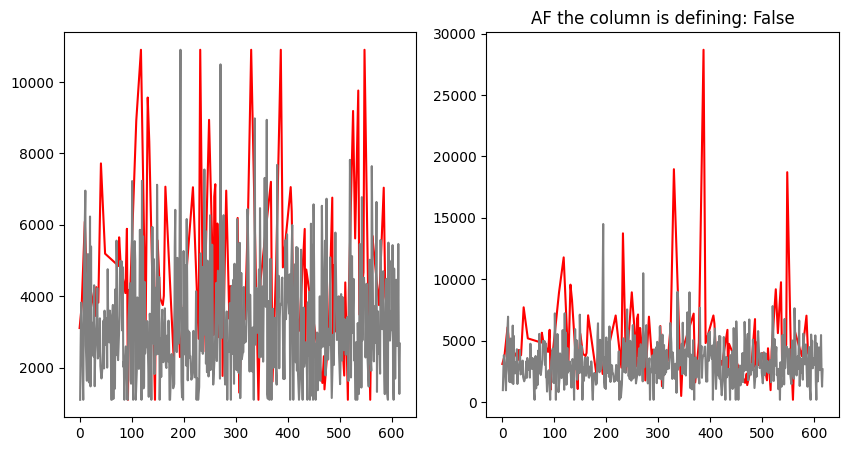

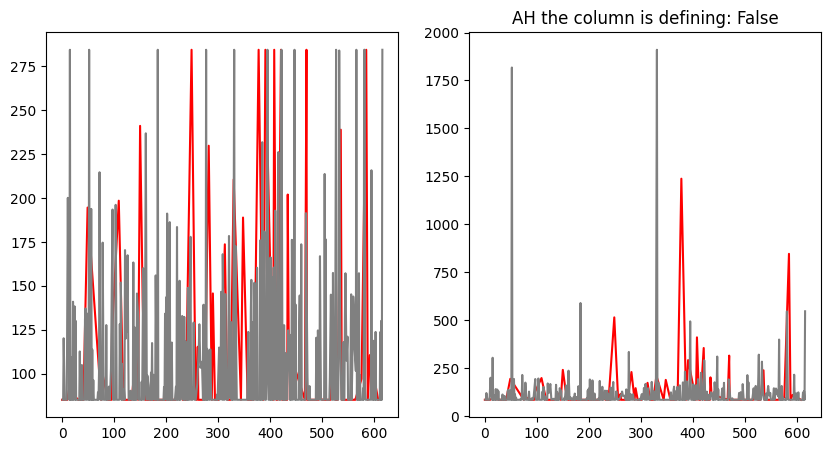

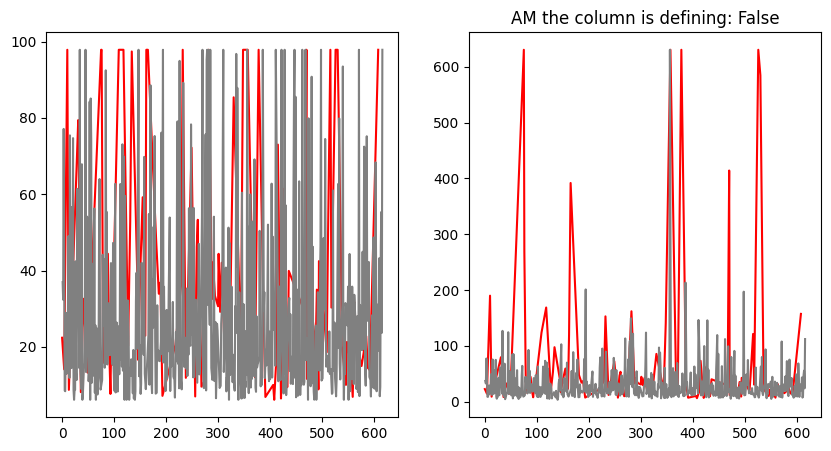

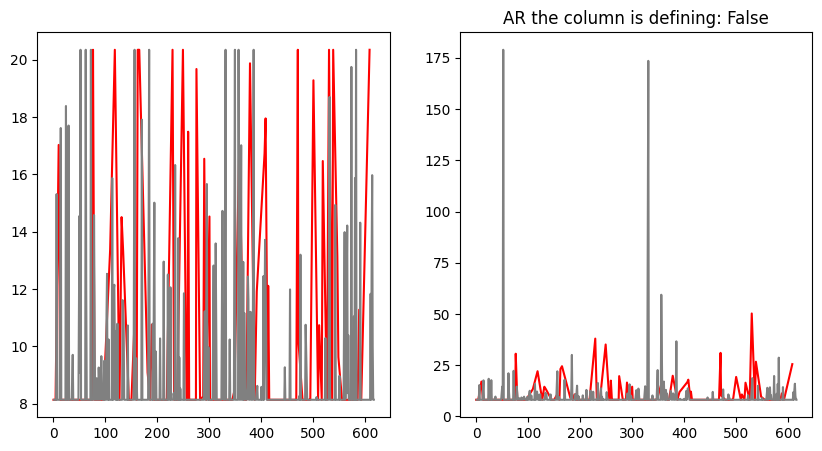

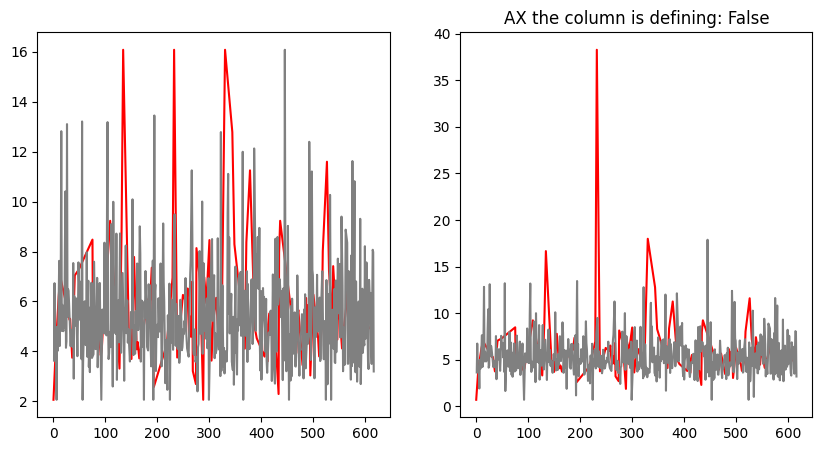

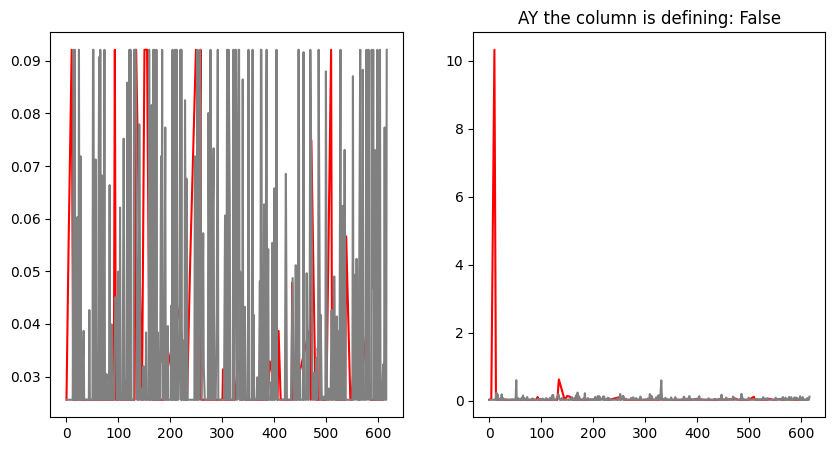

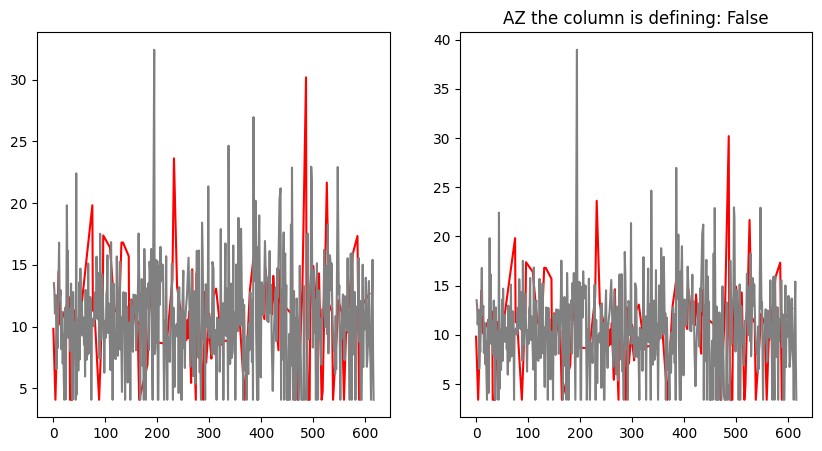

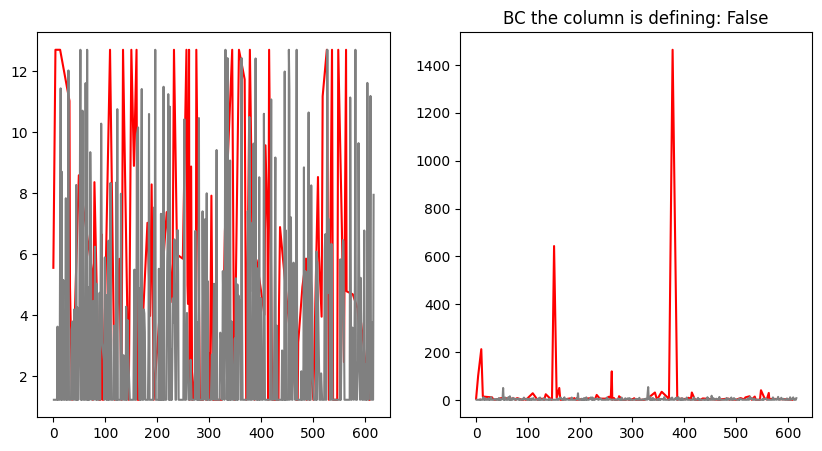

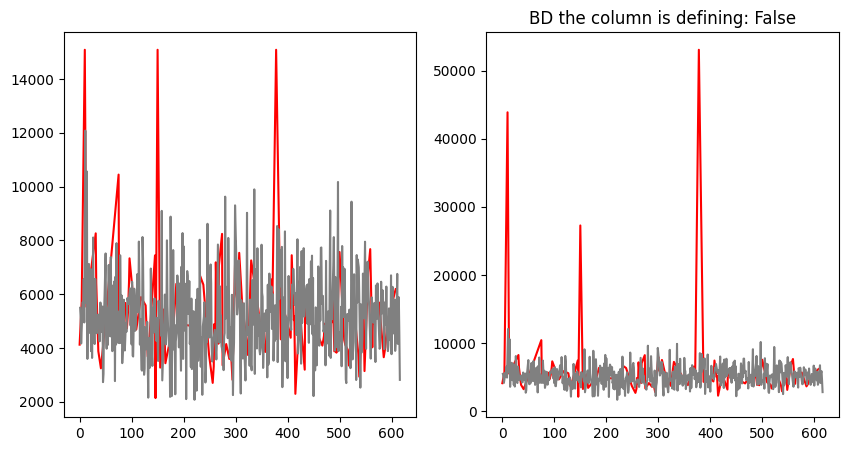

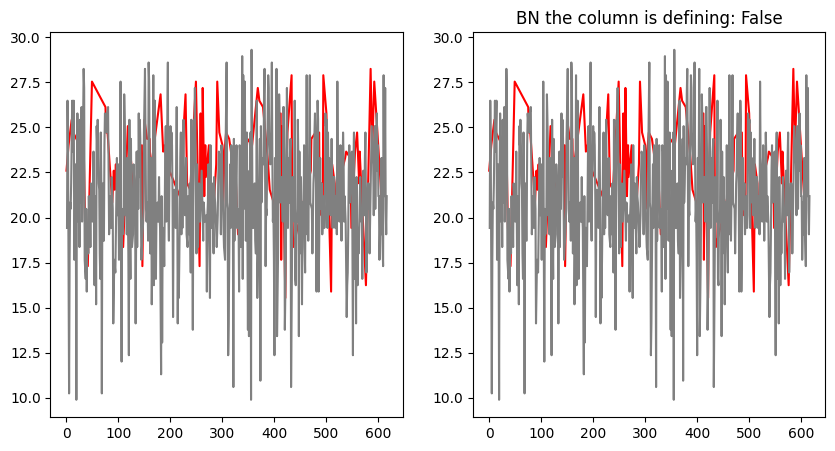

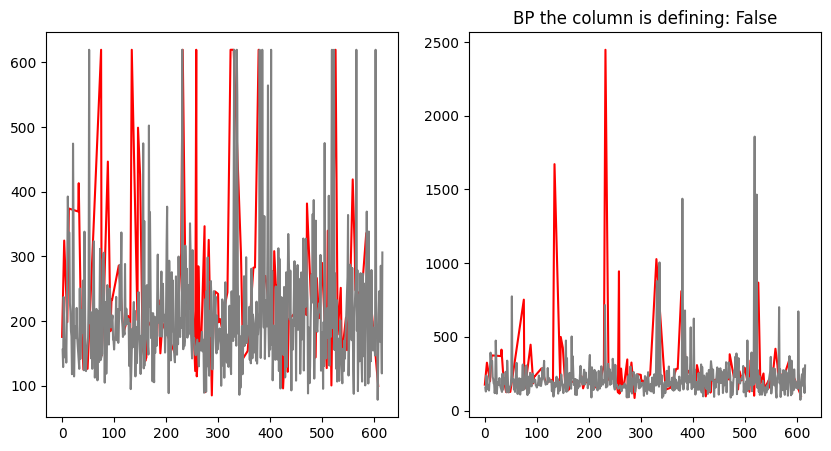

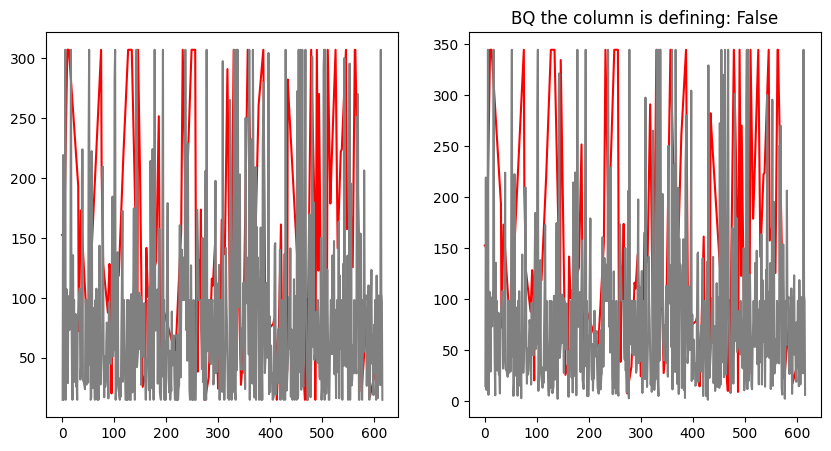

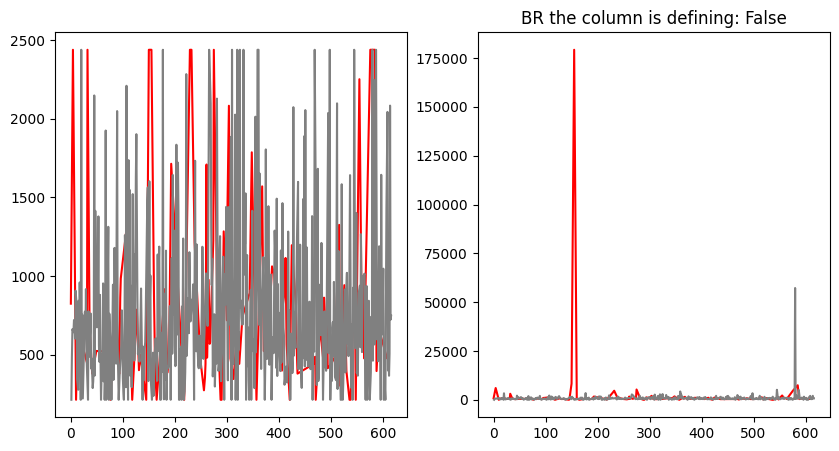

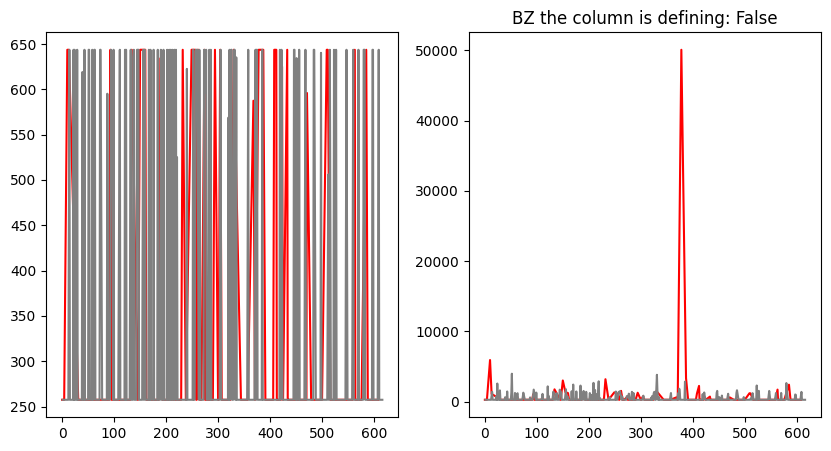

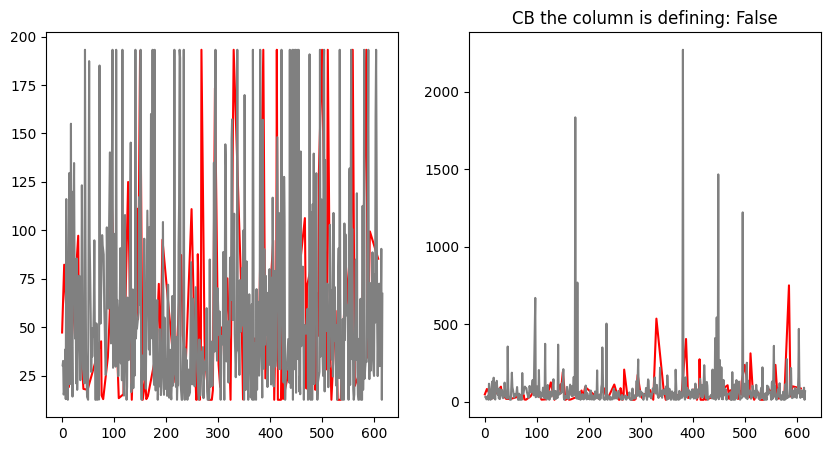

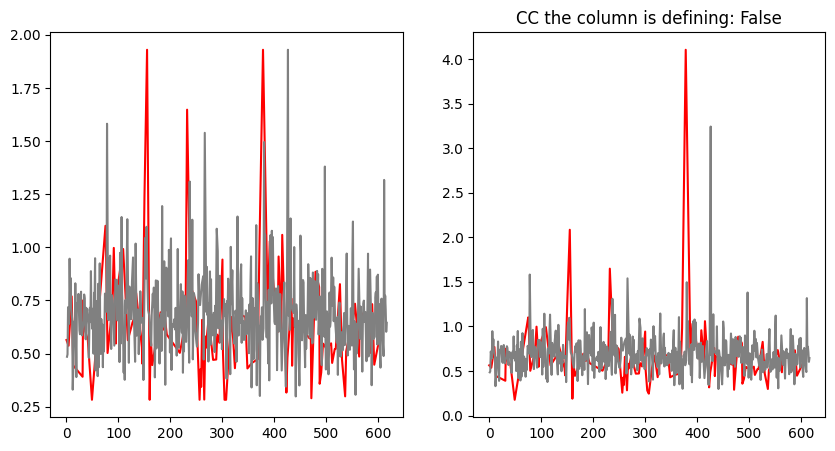

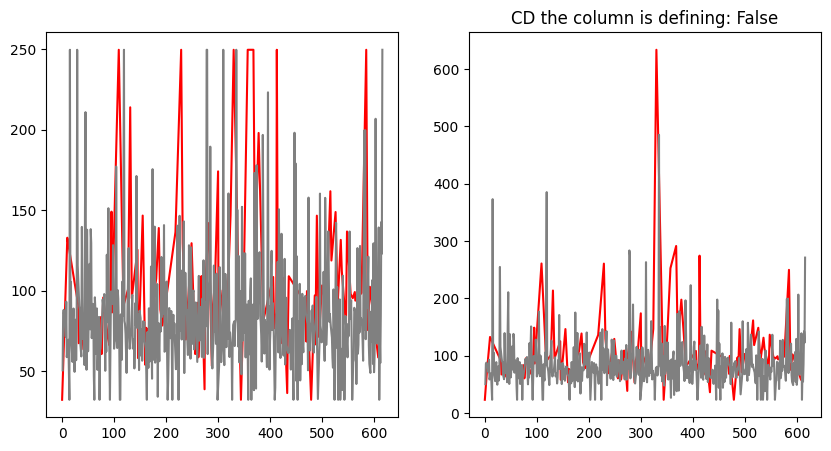

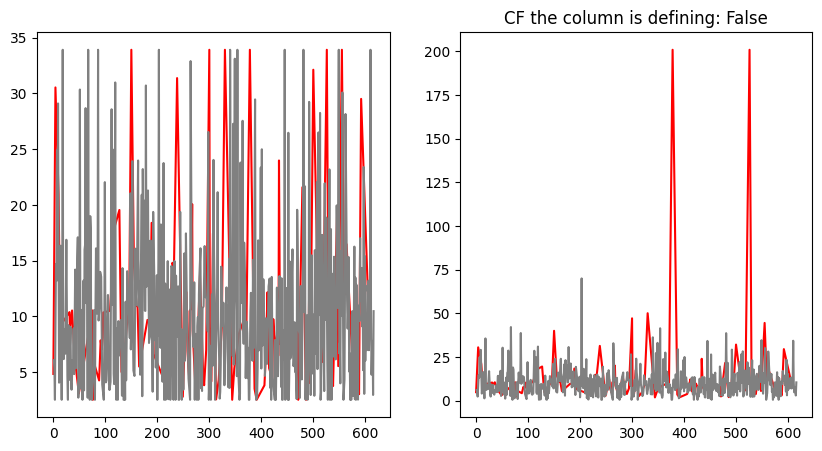

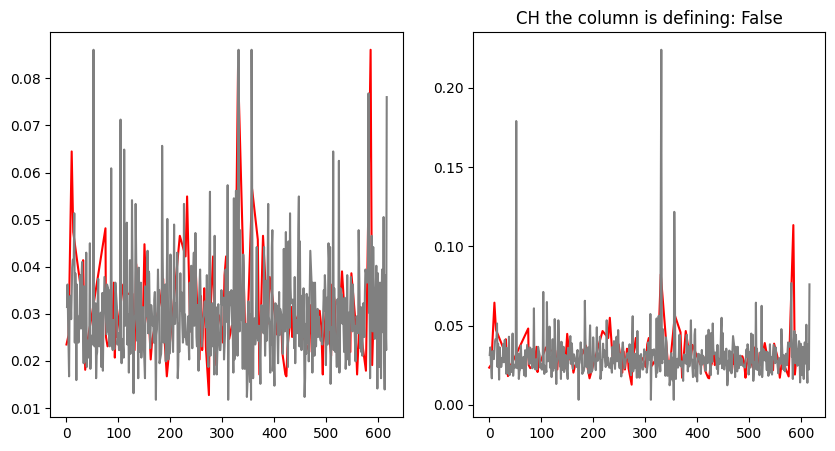

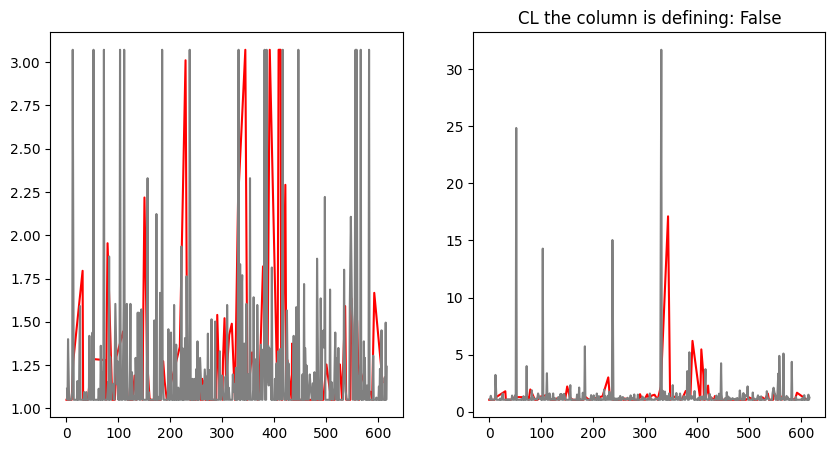

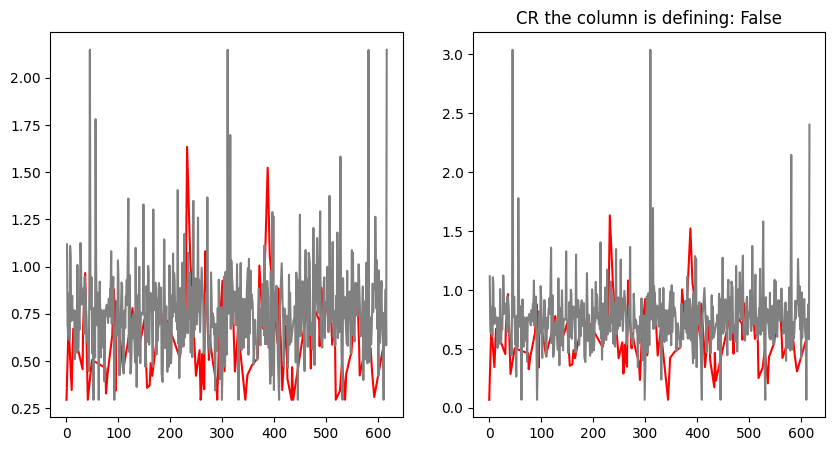

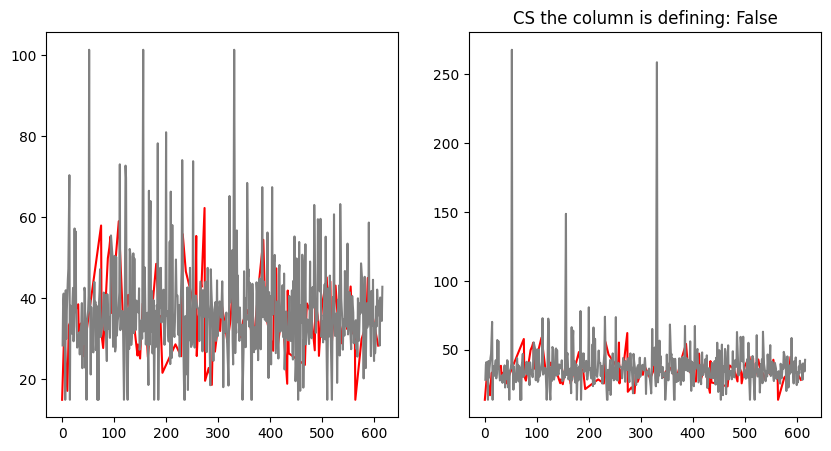

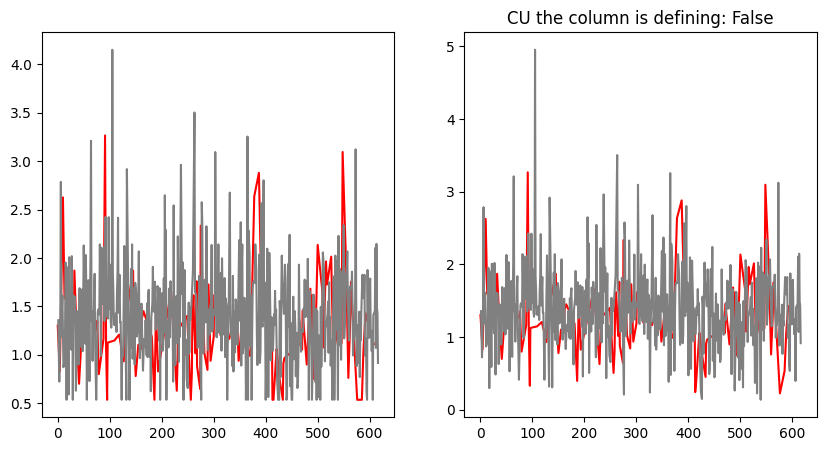

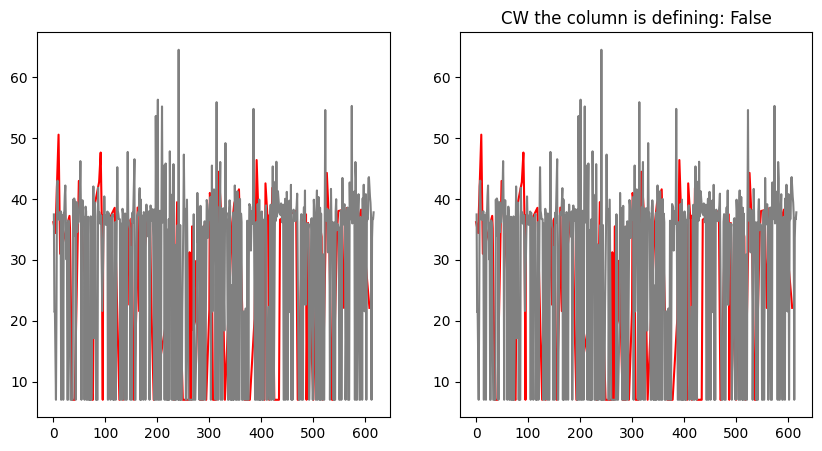

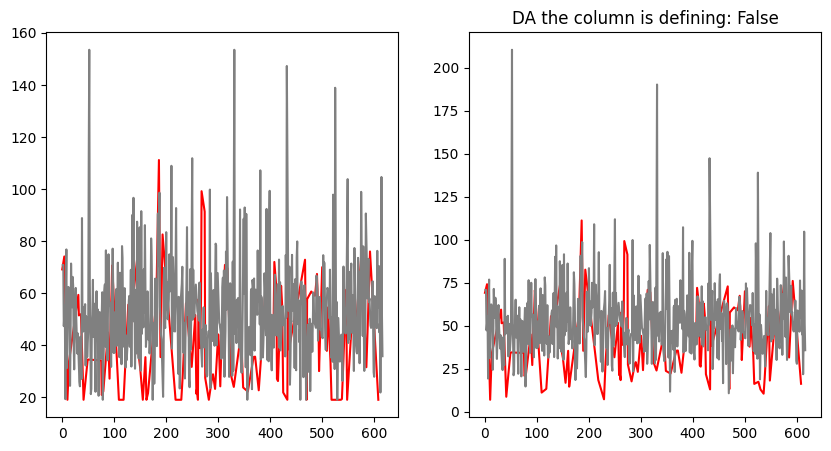

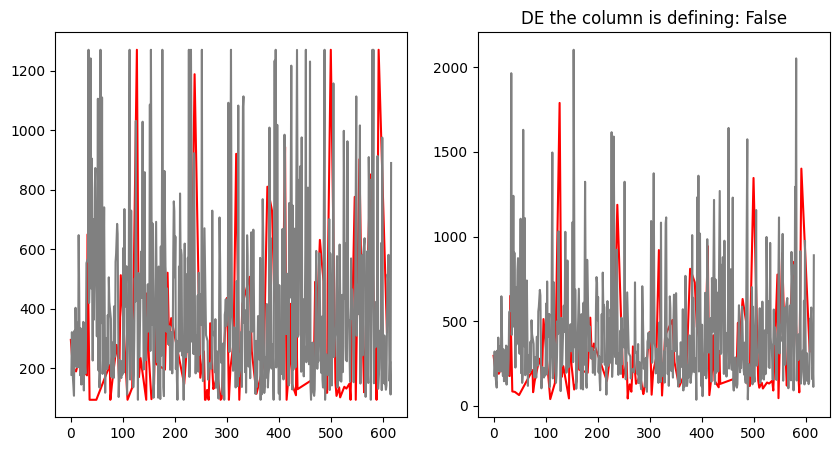

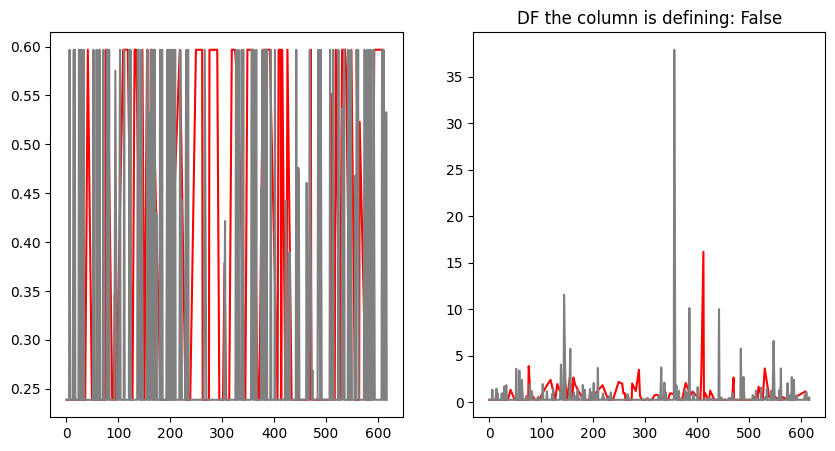

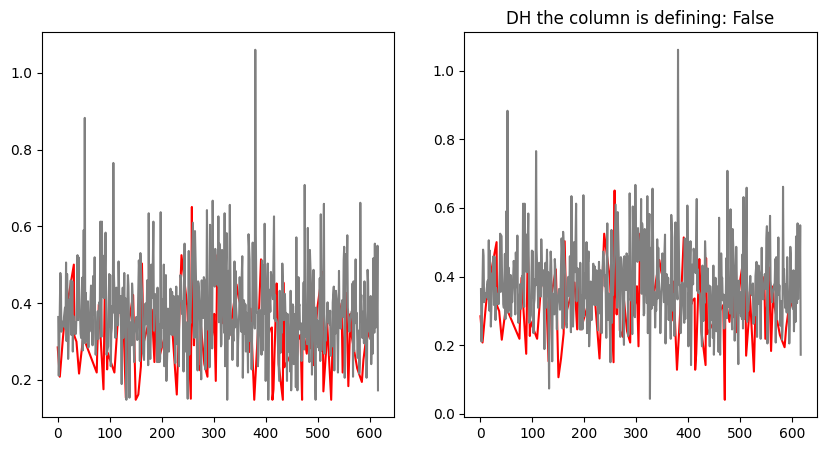

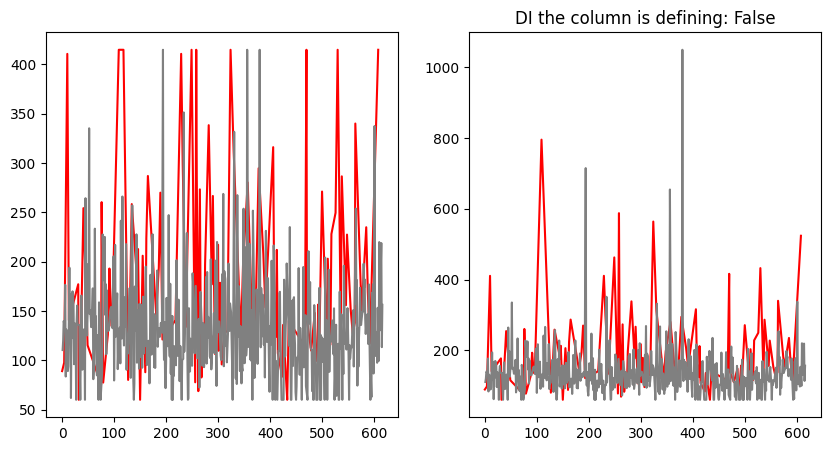

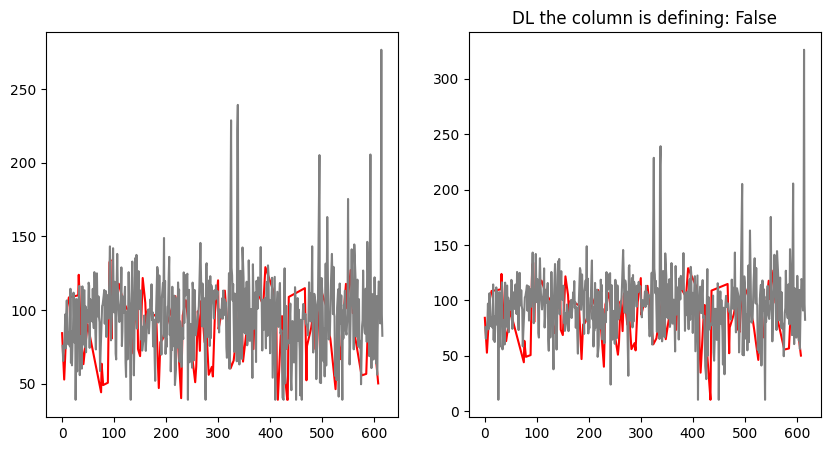

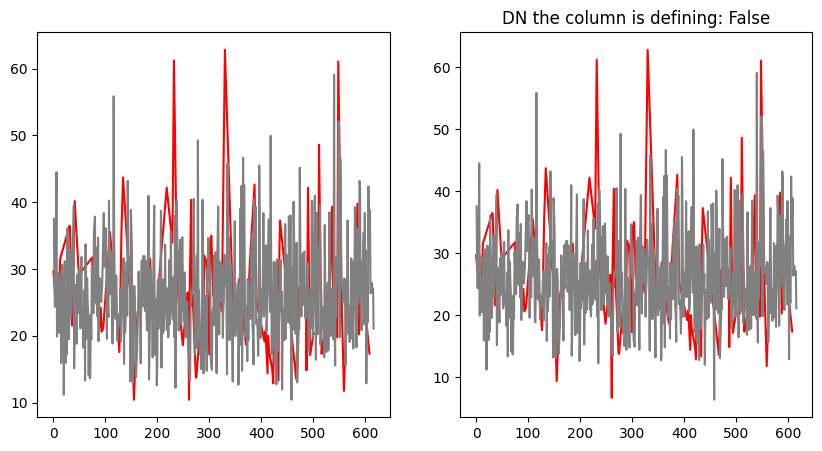

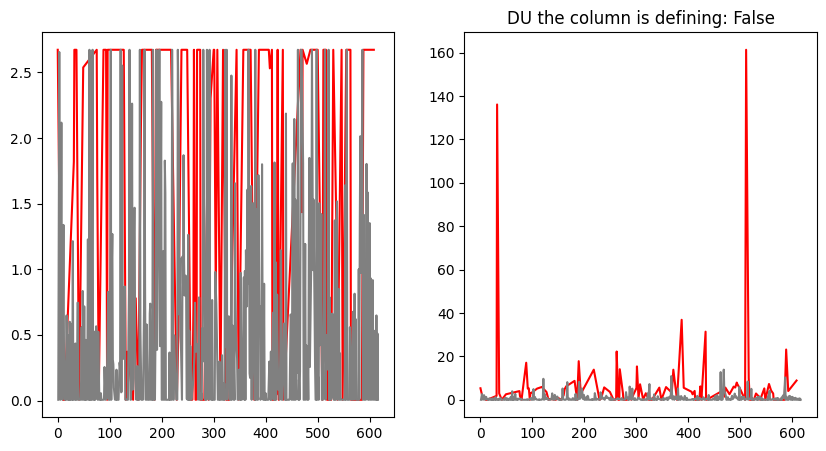

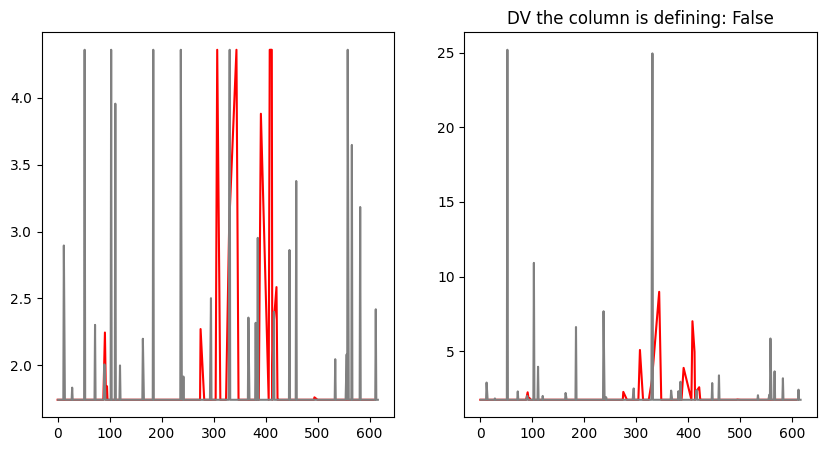

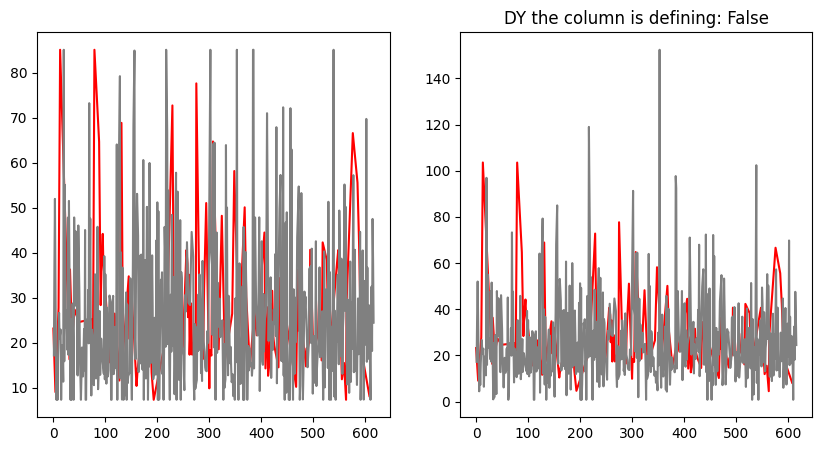

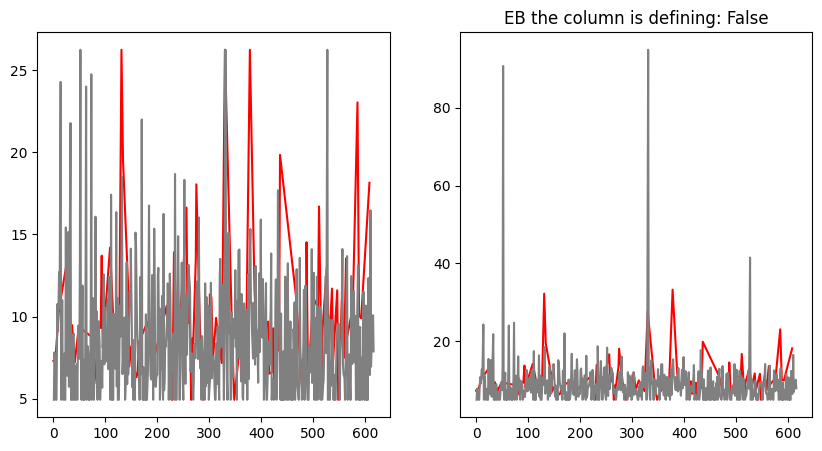

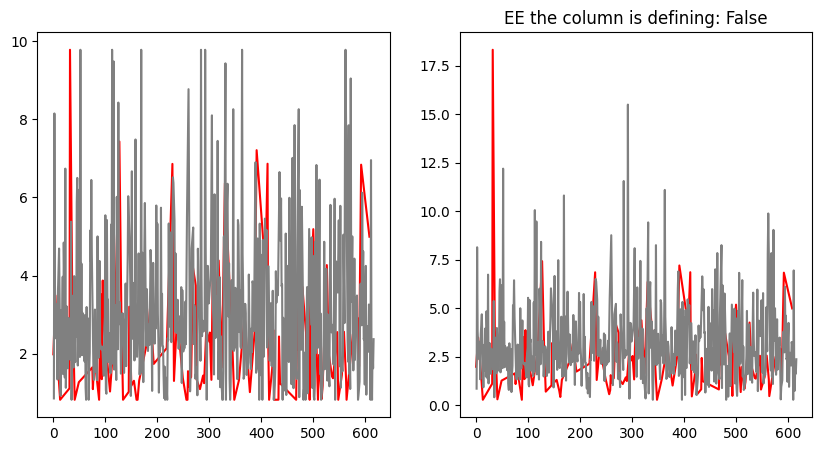

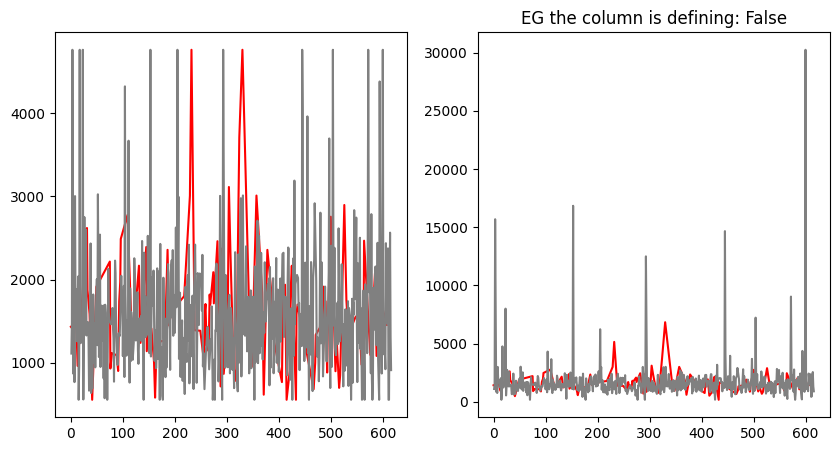

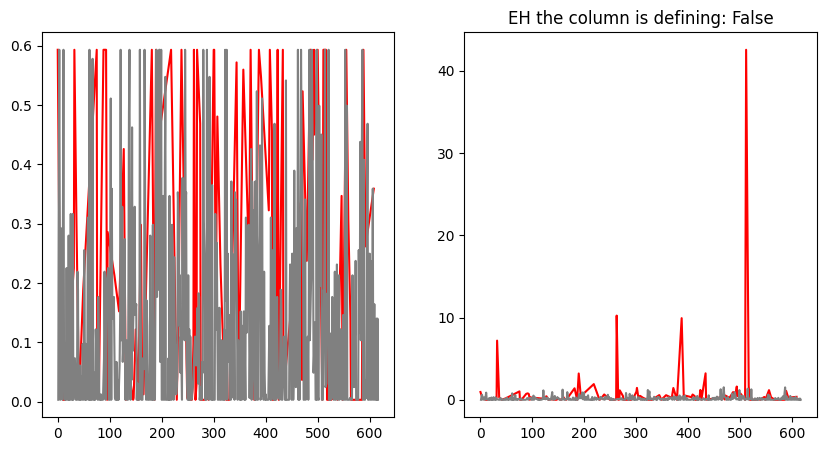

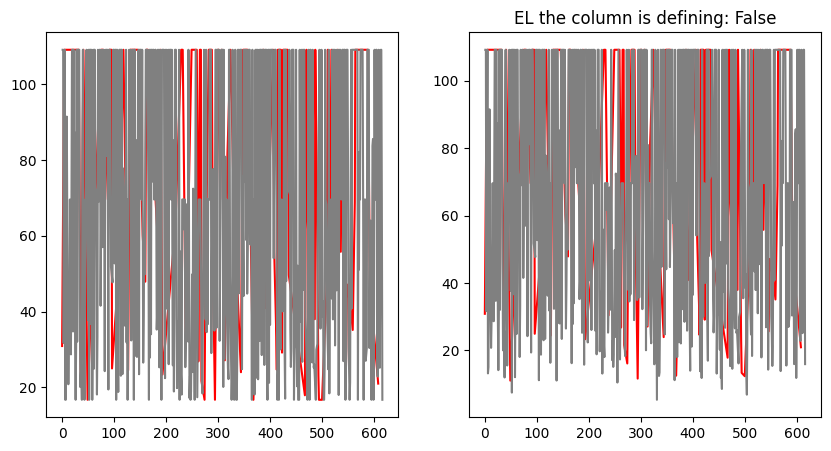

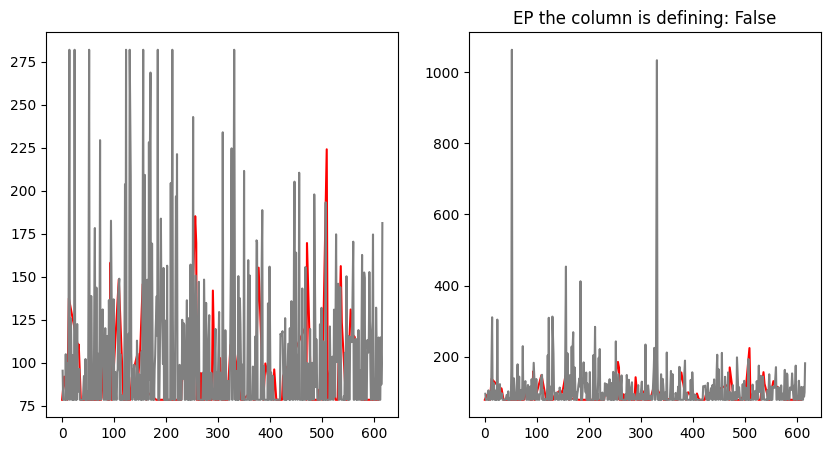

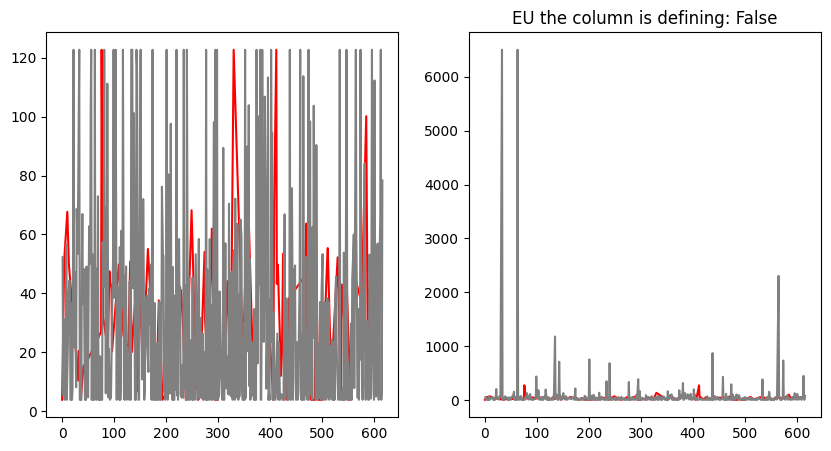

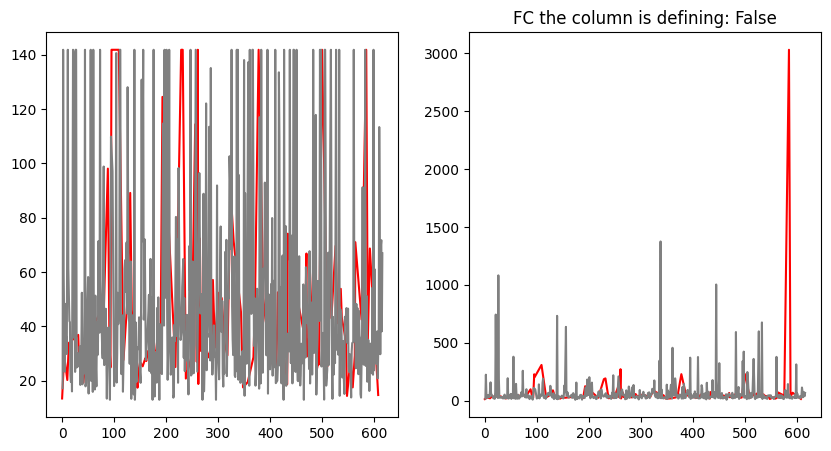

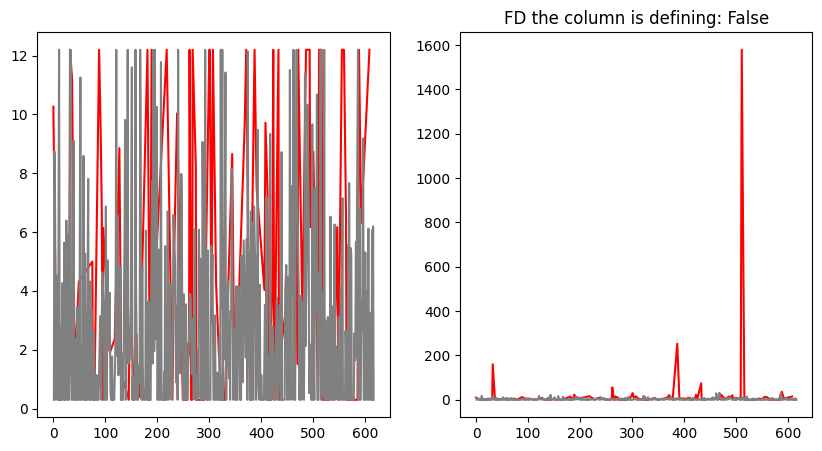

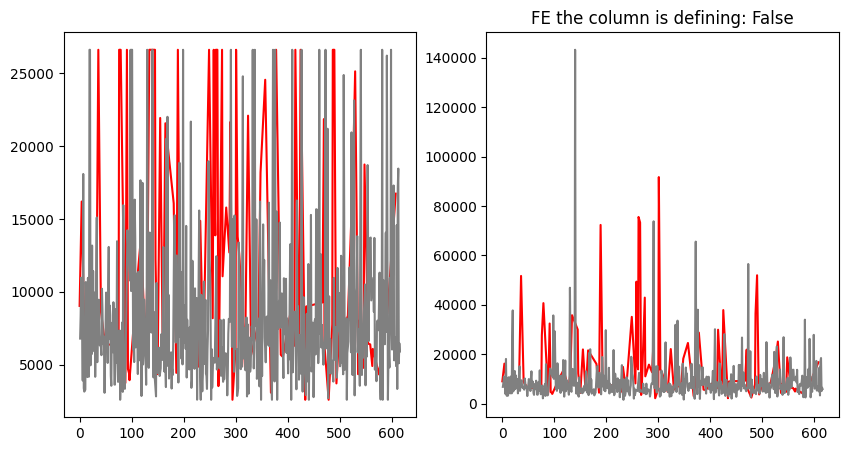

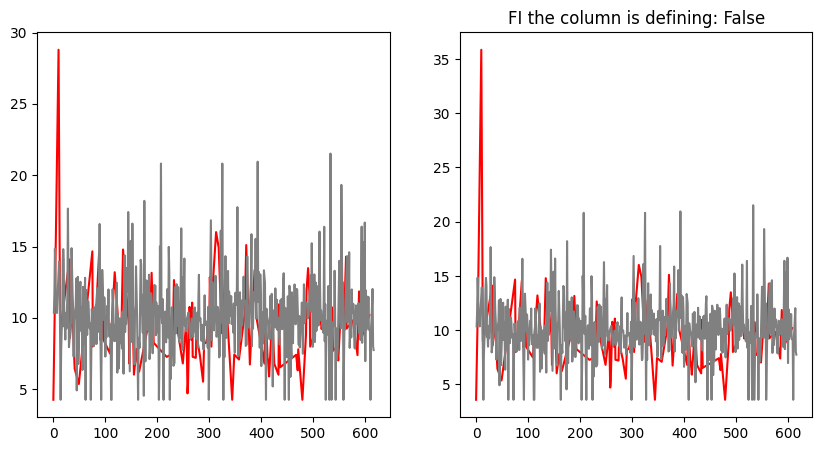

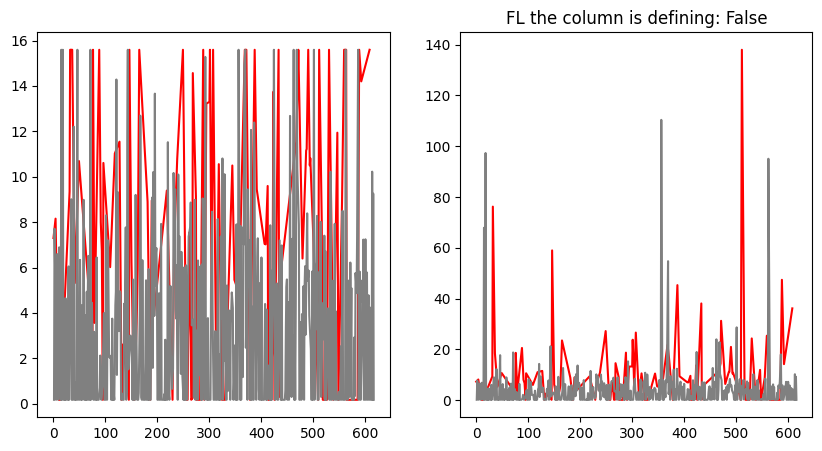

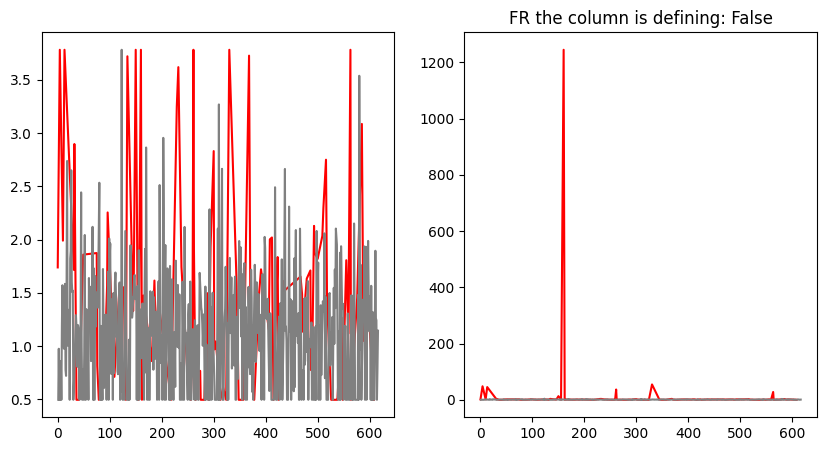

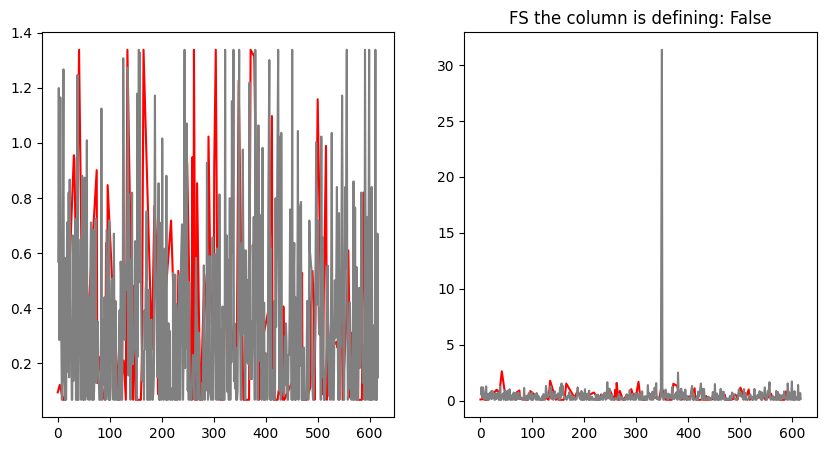

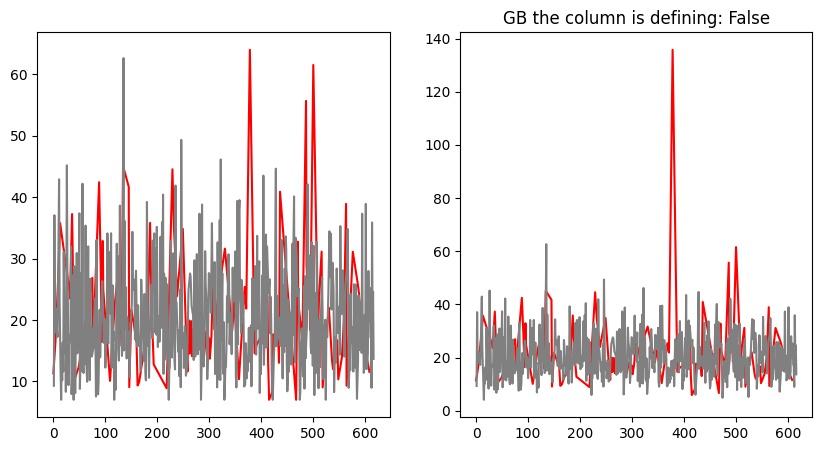

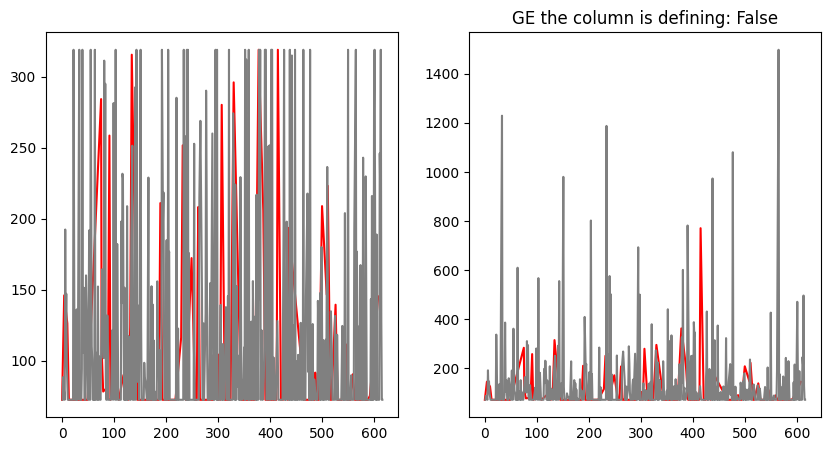

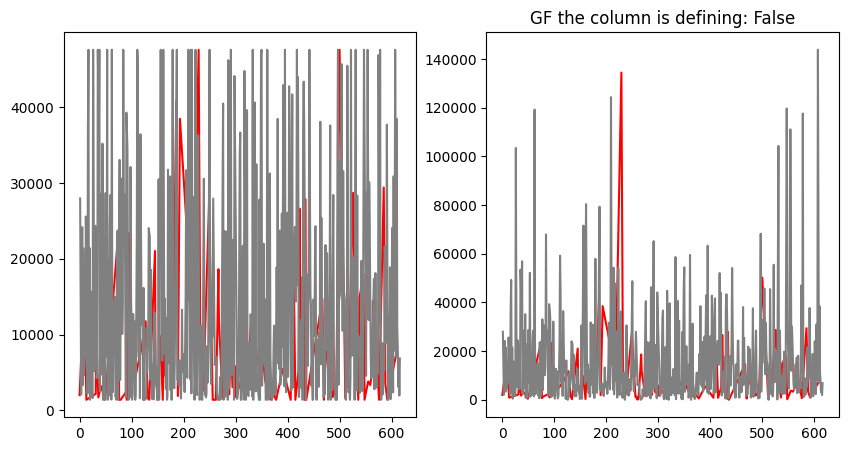

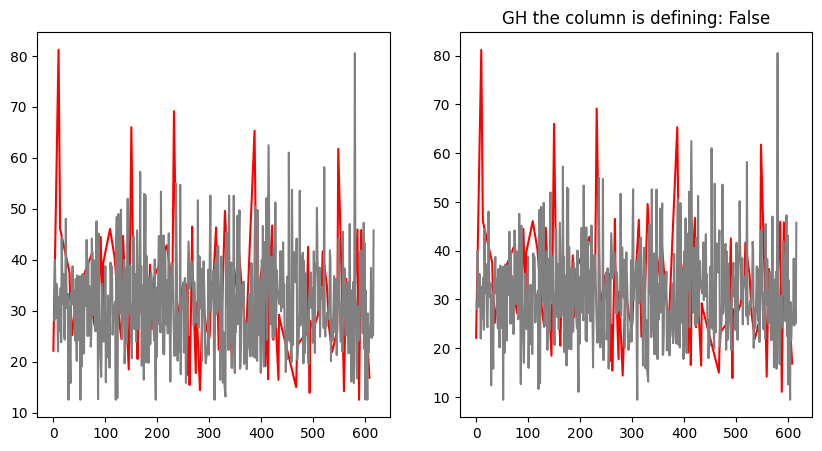

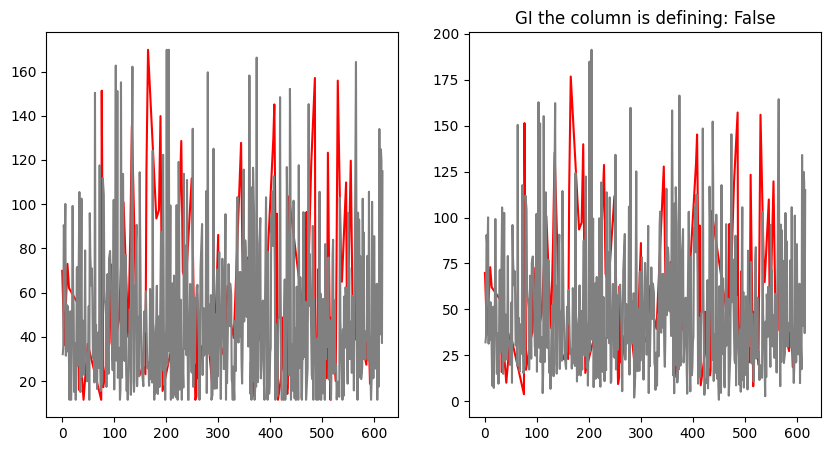

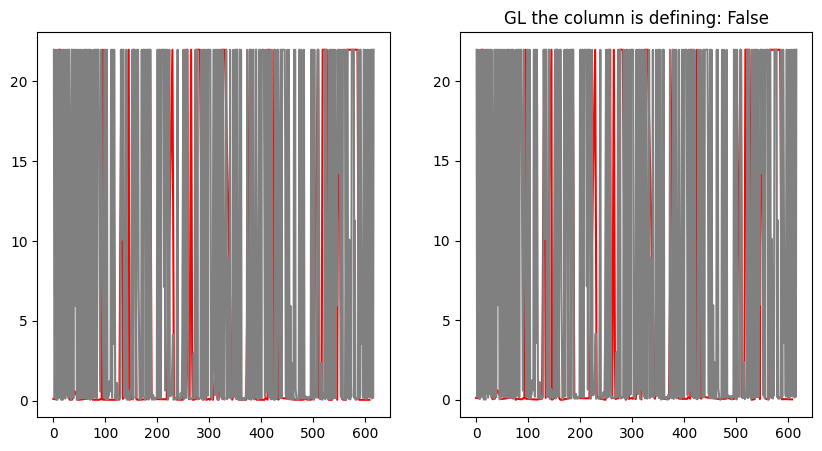

In [183]:
for idx, col in enumerate(numeric_features):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    df_clean.loc[df_clean["Class"]==1, col].plot(kind="line",  color='red', ax=ax[0])
    df.loc[df["Class"]==1, col].plot(kind="line",  color='red', ax=ax[1])
    df_clean.loc[df_clean["Class"]==0, col].plot(kind="line",  color='gray', ax=ax[0])
    df.loc[df["Class"]==0, col].plot(kind="line",  color='gray', ax=ax[1])

    # plt.axhline(y=df_clean.loc[df_clean["Class"]==1, col].min(), color='black', linestyle='--')
    # plt.axhline(y=df_clean.loc[df_clean["Class"]==0, col].max(), color='green', linestyle='--')


    # if df_clean.loc[df_clean["Class"]==1, col].min() > df_clean.loc[df_clean["Class"]==0, col].max():
    #     plt.axhline(y=df_clean.loc[df_clean["Class"]==1, col].min(), color='black', linestyle='-')
    # else:
    #     plt.axhline(y=df_clean.loc[df_clean["Class"]==0, col].max(), color='black', linestyle='-')


    if df_clean.loc[df_clean["Class"]==1, col].min() > df_clean.loc[df_clean["Class"]==0, col].max():
        is_defining = True

    else:
        is_defining = False


    plt.title(f'{col} the column is defining: {is_defining}')
    plt.show()